<a href="https://colab.research.google.com/github/nhjung-phd/X-Learner/blob/main/XLearner_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-Learner 연구 프레임워크 (Colab/Jupyter)
- **목표**: 경기민감(T1) vs 경기둔감(T0) 자산에 대해 X-Learner + ML/DL(옵션)로 CATE/정책 백테스트
- **구성**: 데이터 수집 → 피처/타깃 → μ(결과모델) → Counterfactual → τ/e → 정책 → 평가/시각화

## 1) 의존성 설치


In [ ]:
# Colab에서 필요한 패키지 설치(로컬 Jupyter도 가능)
# - finance-datareader: 거시(일부) 및 주가 데이터 소스
# - yfinance: 야후 파이낸스 티커 기본
# - scikit-learn: ML
# - matplotlib, pandas, numpy: 데이터/시각화
# - (선택) tensorflow: DL 사용 시 설치 (시간/환경 제약 있음)
#!pip -q install -U finance-datareader yfinance scikit-learn matplotlib pandas numpy
# 선택: DL을 쓰고 싶다면 아래 주석 해제
#!pip -q install -U tensorflow

# Fix for ImportError related to numpy/scipy/sklearn version conflicts
# Reinstalling these packages often resolves the issue by ensuring compatible versions
#!pip install -U scikit-learn scipy numpy

In [ ]:
pip install numpy scipy scikit-learn pandas matplotlib yfinance

In [ ]:
pip install -U finance-datareader

  Using cached finance_datareader-0.9.96-py3-none-any.whl.metadata (12 kB)
  Using cached requests_file-2.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached finance_datareader-0.9.96-py3-none-any.whl (48 kB)
Using cached requests_file-2.1.0-py2.py3-none-any.whl (4.2 kB)


In [ ]:
pip install tensorflow

In [ ]:
pip install keras

세션 강제 재시작후 아래 실행

In [ ]:
import numpy, scipy, sklearn, pandas, matplotlib
from sklearn.neural_network import MLPRegressor
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sklearn.__version__)


numpy: 2.0.2
scipy: 1.16.2
sklearn: 1.6.1


## 2) 실험 설정 (티커/기간/옵션)


In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import FinanceDataReader as fdr
import yfinance as yf

# --- 실험 파라미터 ---
CFG = {
    "T1": ["XLY","XLI","XLF"],           # 경기민감 ETF
    "T0": ["BTC-USD","ETH-USD"],         # 경기둔감(암호자산)
    "AUX": ["^GSPC","^VIX"],             # 보조지표
    "start": "2020-01-01",
    "end": "2025-09-21",
    "freq": "D",                         # 일간
    "k_days": 10,                        # forward target 길이
    "seq_window": 60,                    # lag 윈도우
    "standardize": True,                 # 표준화 여부
    "use_macro": True,                   # 거시 변수 사용 여부
    # 매크로(예: VIX, DGS10 등)는 공급원 다양. 여기선 FinanceDataReader + yfinance 혼용.
}
print(CFG)


{'T1': ['XLY', 'XLI', 'XLF'], 'T0': ['BTC-USD', 'ETH-USD'], 'AUX': ['^GSPC', '^VIX'], 'start': '2020-01-01', 'end': '2025-09-21', 'freq': 'D', 'k_days': 10, 'seq_window': 60, 'standardize': True, 'use_macro': True}


## 3) 데이터 수집 유틸


In [ ]:
from datetime import datetime

def _get_price_from_yf(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df, pd.Series):
        return df.to_frame()
    if isinstance(df.columns, pd.MultiIndex):
        # 'Adj Close' 또는 'Close' 우선
        lvl0 = df.columns.get_level_values(0)
        if "Adj Close" in set(lvl0): return df["Adj Close"]
        if "Close" in set(lvl0):     return df["Close"]
        # fallback
        try: return df.xs("Close", level=0, axis=1, drop_level=True)
        except: return df[df.columns.levels[0][-1]]
    # 단일 인덱스
    for col in ["Adj Close","Close"]:
        if col in df.columns:
            c = df[col]
            return c if isinstance(c, pd.DataFrame) else c.to_frame()
    return df

def eq_weight_logret(px: pd.DataFrame) -> pd.Series:
    px = px.ffill().dropna(how="all")
    r = np.log(px).diff()
    return r.mean(axis=1)

def fetch_basket_returns(tickers, start, end):
    raw = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)
    px = _get_price_from_yf(raw)
    if isinstance(px, pd.Series):
        px = px.to_frame()
    return eq_weight_logret(px)

def fetch_macro_series(start, end, use_vix=True):
    macro = {}
    if use_vix:
        try:
            vix = _get_price_from_yf(yf.download("^VIX", start=start, end=end, progress=False)).iloc[:,0]
            vix.name = "VIX"; macro["VIX"] = vix
        except Exception as e:
            print("[macro] VIX fetch failed:", e)
    # 예시: 미국 10년물 금리(=DGS10 유사), 유가(WTI), 달러지수 근사 등
    # FinanceDataReader에 바로 매칭되는 지표가 제한적이라, 여기선 대체/근사 예시만 제공합니다.
    # 필요 시 FRED API 또는 별도 데이터 소스를 연결하세요.
    return pd.DataFrame(macro)

# 실행 예
ret_T1 = fetch_basket_returns(CFG["T1"], CFG["start"], CFG["end"]).rename("ret_T1")
ret_T0 = fetch_basket_returns(CFG["T0"], CFG["start"], CFG["end"]).rename("ret_T0")
data = {"ret_T1": ret_T1, "ret_T0": ret_T0}
macro_df = fetch_macro_series(CFG["start"], CFG["end"]) if CFG["use_macro"] else pd.DataFrame()
print("ret_T1/ret_T0 len:", len(ret_T1), len(ret_T0), "| macro cols:", list(macro_df.columns))


/tmp/ipython-input-2150674087.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = _get_price_from_yf(yf.download("^VIX", start=start, end=end, progress=False)).iloc[:,0]


ret_T1/ret_T0 len: 1437 2090 | macro cols: ['VIX']


## 4) 피처 & 타깃 생성


In [ ]:
def build_lag_features(series_dict: dict, window=60, standardize=True) -> pd.DataFrame:
    # 여러 시계열을 concat하여 lag 피처 생성
    frames = []
    for name, s in series_dict.items():
        s = s.dropna()
        df = pd.concat([s.shift(i) for i in range(1, window+1)], axis=1)
        df.columns = [f"{name}_lag{i}" for i in range(1, window+1)]
        frames.append(df)
    X = pd.concat(frames, axis=1).dropna()
    if standardize:
        X = (X - X.mean()) / (X.std().replace(0, np.nan))
        X = X.replace([np.inf, -np.inf], np.nan).dropna()
    return X

def make_forward_target(r: pd.Series, k: int) -> pd.Series:
    # 다음 k일 누적 log-return (단순 합)
    return r.rolling(k).sum().shift(-k)

# 학습용 피처/타깃
X_base = build_lag_features({"ret_T1": data["ret_T1"], "ret_T0": data["ret_T0"]},
                            window=CFG["seq_window"], standardize=CFG["standardize"])
y1 = make_forward_target(data["ret_T1"], CFG["k_days"]).reindex(X_base.index)
y0 = make_forward_target(data["ret_T0"], CFG["k_days"]).reindex(X_base.index)

if CFG["use_macro"] and not macro_df.empty:
    # 매크로는 단순히 레벨/ffill 후 컬럼 표준화하여 합침(예시)
    m = macro_df.reindex(X_base.index).ffill()
    m = (m - m.mean())/(m.std().replace(0,np.nan))
    X = pd.concat([X_base, m], axis=1).dropna()
else:
    X = X_base.dropna()

print("X/y shapes:", X.shape, y1.dropna().shape, y0.dropna().shape)


X/y shapes: (1376, 121) (1366,) (1369,)


## 5) 시계열 학습/검증 분할


In [ ]:
def split_time_series(X, y, test_ratio=0.2):
    # Align X and y based on their common index and drop NaNs
    combined = pd.concat([X, y], axis=1).dropna()
    X_aligned = combined.iloc[:, :-1]
    y_aligned = combined.iloc[:, -1]

    n = len(X_aligned)
    n_tr = int(n*(1-test_ratio))
    return X_aligned.iloc[:n_tr], X_aligned.iloc[n_tr:], y_aligned.iloc[:n_tr], y_aligned.iloc[n_tr:]

X1_tr, X1_te, y1_tr, y1_te = split_time_series(X, y1)
X0_tr, X0_te, y0_tr, y0_te = split_time_series(X, y0)
print("μ split: ", X1_tr.shape, X1_te.shape, X0_tr.shape, X0_te.shape)

μ split:  (1092, 121) (274, 121) (1095, 121) (274, 121)


# 6) MLP로 우선 테스트

## 6-1)  μ 모델 학습 (baseline: MLPRegressor)


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error

mu_model_name = "MLPRegressor (baseline)"
mu1 = MLPRegressor(hidden_layer_sizes=(128,64), random_state=42, max_iter=300)
mu0 = MLPRegressor(hidden_layer_sizes=(128,64), random_state=42, max_iter=300)

mu1.fit(X1_tr, y1_tr); mu0.fit(X0_tr, y0_tr)

# 전체 구간 μ 예측 (Counterfactual용)
mu1_full = pd.Series(mu1.predict(X), index=X.index, name="mu1")
mu0_full = pd.Series(mu0.predict(X), index=X.index, name="mu0")

# 간단한 검증 지표
corr1 = pd.Series(mu1.predict(X1_te), index=X1_te.index).corr(y1_te)
corr0 = pd.Series(mu0.predict(X0_te), index=X0_te.index).corr(y0_te)
rmse1 = root_mean_squared_error(y1_te, mu1.predict(X1_te))
rmse0 = root_mean_squared_error(y0_te, mu0.predict(X0_te))
print(f"[μ] model={mu_model_name}, corr(mu1)={corr1:.3f}, corr(mu0)={corr0:.3f}, rmse_avg={(rmse1+rmse0)/2:.4f}")

[μ] model=MLPRegressor (baseline), corr(mu1)=-0.070, corr(mu0)=-0.065, rmse_avg=0.2087


## 6-2) Counterfactual 생성


In [ ]:
# 실제 수익률
r1 = data["ret_T1"].reindex(X.index)
r0 = data["ret_T0"].reindex(X.index)

# 주식 투자자의 '코인을 샀다면?' D1 = Y1 - μ0(X)
# 코인 투자자의 '주식을 샀다면?' D0 = μ1(X) - Y0
D1 = (r1 - mu0_full).rename("D1")
D0 = (mu1_full - r0).rename("D0")

D1.name, D0.name


('D1', 'D0')

## 6-3) τ 모델 및 경향점수 e(X)



In [ ]:
from sklearn.linear_model import LogisticRegression
tau_model_name = "MLPRegressor (baseline)"
tau1 = MLPRegressor(hidden_layer_sizes=(128,64), random_state=42, max_iter=300)
tau0 = MLPRegressor(hidden_layer_sizes=(128,64), random_state=42, max_iter=300)

# 동일 X를 사용하여 D1/D0 회귀(단순화)
# 주의: 이 구현은 데모용으로, 군별 학습·검증 설계가 필요할 수 있음
X1_tr2, X1_te2, y1_tr2, y1_te2 = split_time_series(X, D1)
X0_tr2, X0_te2, y0_tr2, y0_te2 = split_time_series(X, D0)
tau1.fit(X1_tr2, y1_tr2); tau0.fit(X0_tr2, y0_tr2)

tau1_full = pd.Series(tau1.predict(X), index=X.index, name="tau1")
tau0_full = pd.Series(tau0.predict(X), index=X.index, name="tau0")

# e(X): ret_T1 > ret_T0 를 1로 하는 간단한 proxy (정확한 PS 추정 아님)
label = (r1 > r0).astype(int)
Xc_tr, Xc_te, yl_tr, yl_te = split_time_series(X, label)
clf = LogisticRegression(max_iter=200)
clf.fit(Xc_tr, yl_tr)
proba = pd.Series(clf.predict_proba(X)[:,1], index=X.index, name="e")

# 최종 τ(x) = e τ0 + (1-e) τ1
tau_final = (proba*tau0_full + (1.0-proba)*tau1_full).rename("tau")
print(f"[τ] model={tau_model_name}, e(X) mean={proba.mean():.4f}")


[τ] model=MLPRegressor (baseline), e(X) mean=0.5024


## 6-4) 정책 & 백테스트 (간단)


In [ ]:
def sharpe_ratio(r, ann=252):
    s = r.std()
    return (r.mean()/s*np.sqrt(ann)) if s>0 else 0.0

def drawdown(cum):
    peak = cum.cummax()
    dd = cum/peak - 1.0
    return dd

# 간단 정책: τ>0 이면 T1, 아니면 T0 (혹은 mu1 > mu0 룰 등)
pick_T1 = (tau_final > 0).astype(int)
strat = (pick_T1*r1 + (1-pick_T1)*r0).rename("strat")
all_t1, all_t0 = r1.rename("all_t1"), r0.rename("all_t0")

df = pd.concat([strat, all_t1, all_t0], axis=1).dropna()
cum = df.cumsum()

met = {
    "Sharpe(strat)": sharpe_ratio(df["strat"]),
    "Sharpe(T1)": sharpe_ratio(df["all_t1"]),
    "Sharpe(T0)": sharpe_ratio(df["all_t0"]),
    "MDD(strat)": drawdown(cum["strat"]).min()
}
pd.DataFrame({"metric": list(met.keys()), "value": list(met.values())})


,metric,value
0,Sharpe(strat),3.103543
1,Sharpe(T1),0.913644
2,Sharpe(T0),0.632125
3,MDD(strat),-0.280821


## 6-5) 시각화


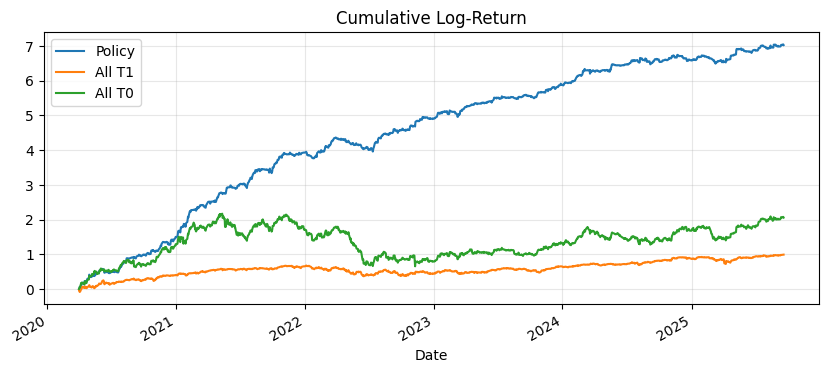

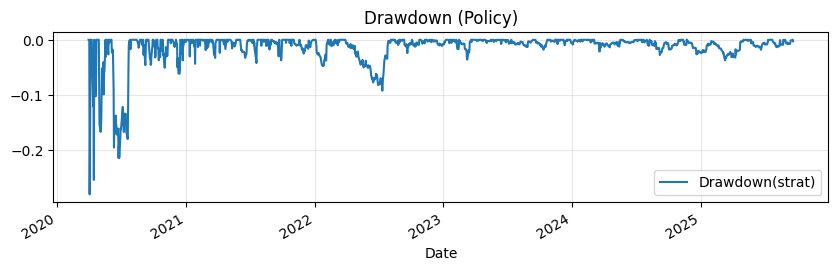

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
cum = df.cumsum()
cum["strat"].plot(ax=ax, label="Policy")
cum["all_t1"].plot(ax=ax, label="All T1")
cum["all_t0"].plot(ax=ax, label="All T0")
ax.grid(True, alpha=0.3); ax.legend(); ax.set_title("Cumulative Log-Return")
plt.show()

# 드로다운
fig, ax = plt.subplots(1,1, figsize=(10,2.5))
dd = drawdown(cum["strat"])
dd.plot(ax=ax, label="Drawdown(strat)")
ax.grid(True, alpha=0.3); ax.legend(); ax.set_title("Drawdown (Policy)")
plt.show()


# 7) MLP,LSTM,GRU,CNN, RNN 등 모델로 해보기

## 7-1) 딥러닝모델 관련함수정의

In [ ]:
# core/model_selector.py (혹은 노트북 셀에 정의)

import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# TensorFlow/Keras가 있으면 딥러닝 모델도 사용
try:
    import tensorflow as tf
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, Flatten
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False


# --- 공통 wrapper ---
class SklearnWrapper:
    """sklearn 호환 모델을 공통 predict 인터페이스로 감쌈"""
    def __init__(self, model, fallback_from=None):
        self.model = model
        self._fallback_from = fallback_from
    def fit(self, X, y):
        self.model.fit(X, y)
    def predict(self, X):
        return self.model.predict(X)


class KerasSeqRegressor:
    """간단 시계열 회귀 모델 (LSTM/GRU/RNN/CNN)
       - X(2D)를 (n, window, features)로 리쉐이프
       - p % window != 0 이면 남는 컬럼을 잘라서 맞춤 (경고 로그 저장)
    """
    def __init__(self, kind="LSTM", window=60, lr=1e-3, epochs=20, batch=64, verbose=0):
        self.kind = kind
        self.window = window
        self.lr = lr
        self.epochs = epochs
        self.batch = batch
        self.verbose = verbose
        self.model = None
        self._trim_cols = 0          # 잘라낸 컬럼 수 기록
        self._n_features = None      # window당 feature 개수 기록

    def _ensure_3d(self, X2d):
        import numpy as np, pandas as pd

        X_in = X2d.values if hasattr(X2d, "values") else X2d
        n, p = X_in.shape
        rem = p % self.window
        if rem != 0:
            # 남는 컬럼은 잘라내기 (매크로 등 window 블록 외 컬럼)
            X_in = X_in[:, :p - rem]
            self._trim_cols = rem
        else:
            self._trim_cols = 0
        p2 = X_in.shape[1]
        if p2 == 0:
            raise ValueError(f"[{self.kind}] 입력 컬럼이 window({self.window}) 배수가 아닙니다(p={p}). "
                             f"lag 피처를 추가하거나 window를 조정하세요.")
        self._n_features = p2 // self.window
        X_3d = X_in.reshape((n, self.window, self._n_features))
        return X_3d

    def _build(self, input_dim):
        # Keras 권장 방식: Input 레이어를 먼저 두고, 이후 레이어들에는 input_shape를 넘기지 않음
        from tensorflow.keras import Sequential, Input
        from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, Flatten
        import tensorflow as tf

        model = Sequential()
        model.add(Input(shape=(self.window, input_dim)))   # ✅ 입력 형태 지정 (경고 제거 포인트)

        if self.kind == "LSTM":
            model.add(LSTM(32))
        elif self.kind == "GRU":
            model.add(GRU(32))
        elif self.kind == "RNN":
            model.add(SimpleRNN(32))
        elif self.kind == "CNN":
            model.add(Conv1D(32, 3, activation="relu"))
            model.add(Flatten())

        model.add(Dense(1))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr), loss="mse")
        return model


    def fit(self, X, y):
        import numpy as np
        X_3d = self._ensure_3d(X)
        y_in = y.values if hasattr(y, "values") else y
        self.model = self._build(X_3d.shape[2])
        if self._trim_cols:
            print(f"[{self.kind}] WARNING: window={self.window} 배수가 아니어서 마지막 {self._trim_cols}개 컬럼을 무시했습니다.")
        self.model.fit(X_3d, y_in, epochs=self.epochs, batch_size=self.batch, verbose=self.verbose)

    def predict(self, X):
        X_3d = self._ensure_3d(X)
        if self._trim_cols:
            print(f"[{self.kind}] NOTE: 예측 시에도 마지막 {self._trim_cols}개 컬럼을 무시합니다.")
        return self.model.predict(X_3d, verbose=0).flatten()



# --- 메인 선택 함수 ---
def get_regressor(kind="MLP", window=60, lr=1e-3, epochs=20, batch=64):
    """
    kind: ["MLP","LGBM","XGB","LSTM","GRU","CNN","RNN"]
    """
    if kind == "MLP":
        return SklearnWrapper(MLPRegressor(hidden_layer_sizes=(128,64), max_iter=300, random_state=42))
    elif kind == "LGBM":
        return SklearnWrapper(LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42))
    elif kind == "XGB":
        return SklearnWrapper(XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42))
    elif kind in ["LSTM","GRU","CNN","RNN"]:
        if TF_AVAILABLE:
            return KerasSeqRegressor(kind=kind, window=window, lr=lr, epochs=epochs, batch=batch)
        else:
            # TensorFlow 없으면 fallback → MLP
            return SklearnWrapper(
                MLPRegressor(hidden_layer_sizes=(128,64), max_iter=300, random_state=42),
                fallback_from=kind
            )
    else:
        raise ValueError(f"Unknown model kind: {kind}")

In [ ]:
def add_macro_lags(macro_df, window=60):
    # macro의 각 컬럼에 대해서 lag1..lagW 생성
    frames = []
    for col in macro_df.columns:
        s = macro_df[col].dropna()
        df = pd.concat([s.shift(i) for i in range(1, window+1)], axis=1)
        df.columns = [f"{col}_lag{i}" for i in range(1, window+1)]
        frames.append(df)
    return pd.concat(frames, axis=1)

# 기존 X_base에 매크로 래그를 합치기
if CFG["use_macro"] and not macro_df.empty:
    macro_lag = add_macro_lags(macro_df.reindex(X_base.index).ffill(), window=CFG["seq_window"])
    macro_lag = (macro_lag - macro_lag.mean()) / (macro_lag.std().replace(0, np.nan))
    X = pd.concat([X_base, macro_lag], axis=1).dropna()
else:
    X = X_base.dropna()


## 7-2) 딥러닝 테스트 1

In [ ]:
# =============================
# 모델 스윗프(MLP/LSTM/GRU/CNN/RNN) 성능 비교 루프
# =============================
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LogisticRegression

def _align_xy(X, y):
    comb = pd.concat([X, y], axis=1).dropna()
    return comb.iloc[:,:-1], comb.iloc[:,-1]

def _split(X, y, test_ratio=0.2):
    n = len(X); n_tr = int(n * (1 - test_ratio))
    return X.iloc[:n_tr], X.iloc[n_tr:], y.iloc[:n_tr], y.iloc[n_tr:]

def sharpe_ratio(r, ann=252):
    s = r.std()
    return (r.mean()/s*np.sqrt(ann)) if s > 0 else 0.0

def drawdown(cum):
    peak = cum.cummax()
    return cum/peak - 1.0

def run_one(kind:str, CFG, X, y1, y0, data):
    """
    kind: 'MLP' | 'LSTM' | 'GRU' | 'CNN' | 'RNN'
    반환: dict(metrics)
    """
    win = CFG["seq_window"]

    # === μ 학습 (kind 사용) ===
    X1, y1a = _align_xy(X, y1)
    X0, y0a = _align_xy(X, y0)
    n = min(len(X1), len(X0))
    X1, y1a = X1.iloc[:n], y1a.iloc[:n]
    X0, y0a = X0.iloc[:n], y0a.iloc[:n]
    X1_tr, X1_te, y1_tr, y1_te = _split(X1, y1a)
    X0_tr, X0_te, y0_tr, y0_te = _split(X0, y0a)

    mu1 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    mu0 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)

    used_mu1 = f"{kind}" + (f"(fallback→MLP)" if hasattr(mu1, "_fallback_from") else "")
    used_mu0 = f"{kind}" + (f"(fallback→MLP)" if hasattr(mu0, "_fallback_from") else "")

    mu1.fit(X1_tr, y1_tr); mu0.fit(X0_tr, y0_tr)

    mu1_full = pd.Series(mu1.predict(X), index=X.index, name="mu1")
    mu0_full = pd.Series(mu0.predict(X), index=X.index, name="mu0")

    p1_te = pd.Series(mu1.predict(X1_te), index=X1_te.index)
    p0_te = pd.Series(mu0.predict(X0_te), index=X0_te.index)
    corr1 = p1_te.corr(y1_te); corr0 = p0_te.corr(y0_te)
    rmse1 = root_mean_squared_error(y1_te, p1_te)
    rmse0 = root_mean_squared_error(y0_te, p0_te)
    rmse_avg = (rmse1 + rmse0) / 2

    # === Counterfactual / τ / e ===
    r1 = data["ret_T1"].reindex(X.index)
    r0 = data["ret_T0"].reindex(X.index)
    D1 = (r1 - mu0_full).rename("D1")
    D0 = (mu1_full - r0).rename("D0")

    X1b, y1b = _align_xy(X, D1)
    X0b, y0b = _align_xy(X, D0)
    n2 = min(len(X1b), len(X0b))
    X1b, y1b = X1b.iloc[:n2], y1b.iloc[:n2]
    X0b, y0b = X0b.iloc[:n2], y0b.iloc[:n2]
    X1_tr2, X1_te2, y1_tr2, y1_te2 = _split(X1b, y1b)
    X0_tr2, X0_te2, y0_tr2, y0_te2 = _split(X0b, y0b)

    tau1 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    tau0 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    used_tau1 = f"{kind}" + (f"(fallback→MLP)" if hasattr(tau1, "_fallback_from") else "")
    used_tau0 = f"{kind}" + (f"(fallback→MLP)" if hasattr(tau0, "_fallback_from") else "")

    tau1.fit(X1_tr2, y1_tr2); tau0.fit(X0_tr2, y0_tr2)

    tau1_full = pd.Series(tau1.predict(X), index=X.index, name="tau1")
    tau0_full = pd.Series(tau0.predict(X), index=X.index, name="tau0")

    # e(X): 간단 proxy (ret_T1 > ret_T0)
    label = (r1 > r0).astype(int)
    Xc, yl = _align_xy(X, label)
    Xc_tr, Xc_te, yl_tr, yl_te = _split(Xc, yl)
    clf = LogisticRegression(max_iter=200)
    clf.fit(Xc_tr, yl_tr)
    proba = pd.Series(clf.predict_proba(X)[:,1], index=X.index, name="e")

    tau_final = (proba * tau0_full + (1.0 - proba) * tau1_full).rename("tau")

    # === 정책 백테스트 ===
    pick_T1 = (tau_final > 0).astype(int)
    strat = (pick_T1*r1 + (1-pick_T1)*r0).rename("strat")
    all_t1, all_t0 = r1.rename("all_t1"), r0.rename("all_t0")
    df = pd.concat([strat, all_t1, all_t0], axis=1).dropna()
    cum = df.cumsum()

    sharpe_strat = sharpe_ratio(df["strat"])
    sharpe_t1    = sharpe_ratio(df["all_t1"])
    sharpe_t0    = sharpe_ratio(df["all_t0"])
    mdd_strat    = drawdown(cum["strat"]).min()

    # τ-진단 보조(선택): μ갭과 상관
    mu_gap = (mu1_full - mu0_full).reindex(tau_final.index)
    corr_tau_muGap = float(tau_final.corr(mu_gap)) if mu_gap.notna().any() else np.nan

    return {
        "kind": kind,
        "mu_used(mu1)": used_mu1,
        "mu_used(mu0)": used_mu0,
        "tau_used(tau1)": used_tau1,
        "tau_used(tau0)": used_tau0,
        "corr(mu1)": float(corr1) if pd.notna(corr1) else np.nan,
        "corr(mu0)": float(corr0) if pd.notna(corr0) else np.nan,
        "rmse_avg": float(rmse_avg),
        "mean_e": float(proba.mean()),
        "Sharpe(strat)": float(sharpe_strat),
        "Sharpe(T1)": float(sharpe_t1),
        "Sharpe(T0)": float(sharpe_t0),
        "MDD(strat)": float(mdd_strat),
        "corr(tau, mu_gap)": float(corr_tau_muGap)
    }

# === 실행: 동일 kind를 μ/τ 모두에 적용하며 스윕 ===
MODEL_LIST = ["MLP","LSTM","GRU","CNN","RNN"]
results = []
for kind in MODEL_LIST:
    print(f"\n=== RUN {kind} ===")
    res = run_one(kind, CFG, X, y1, y0, data)
    results.append(res)

results_df = pd.DataFrame(results)
display(results_df)

# 정렬 보기(Sharpe 내림차순)
display(results_df.sort_values("Sharpe(strat)", ascending=False))



=== RUN MLP ===

=== RUN LSTM ===

=== RUN GRU ===

=== RUN CNN ===

=== RUN RNN ===


,kind,mu_used(mu1),mu_used(mu0),tau_used(tau1),tau_used(tau0),corr(mu1),corr(mu0),rmse_avg,mean_e,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat),"corr(tau, mu_gap)"
0,MLP,MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),-0.042321,0.102508,0.242539,0.501065,3.070696,0.879696,0.493043,-0.980659,0.391901
1,LSTM,LSTM,LSTM,LSTM,LSTM,0.038289,0.118680,0.061894,0.501065,1.177090,0.879696,0.493043,-0.980659,0.283384
2,GRU,GRU,GRU,GRU,GRU,-0.106159,0.116456,0.065705,0.501065,0.667118,0.879696,0.493043,-0.542752,0.730370
3,CNN,CNN,CNN,CNN,CNN,0.114803,-0.003462,0.115586,0.501065,2.315800,0.879696,0.493043,-0.434629,0.535224
4,RNN,RNN,RNN,RNN,RNN,-0.106798,-0.063330,0.110108,0.501065,1.274984,0.879696,0.493043,-0.980659,0.328551


,kind,mu_used(mu1),mu_used(mu0),tau_used(tau1),tau_used(tau0),corr(mu1),corr(mu0),rmse_avg,mean_e,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat),"corr(tau, mu_gap)"
0,MLP,MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),-0.042321,0.102508,0.242539,0.501065,3.070696,0.879696,0.493043,-0.980659,0.391901
3,CNN,CNN,CNN,CNN,CNN,0.114803,-0.003462,0.115586,0.501065,2.315800,0.879696,0.493043,-0.434629,0.535224
4,RNN,RNN,RNN,RNN,RNN,-0.106798,-0.063330,0.110108,0.501065,1.274984,0.879696,0.493043,-0.980659,0.328551
1,LSTM,LSTM,LSTM,LSTM,LSTM,0.038289,0.118680,0.061894,0.501065,1.177090,0.879696,0.493043,-0.980659,0.283384
2,GRU,GRU,GRU,GRU,GRU,-0.106159,0.116456,0.065705,0.501065,0.667118,0.879696,0.493043,-0.542752,0.730370


## 7-2) 딥러닝 전 모델 테스트 함수 run_one 1

In [ ]:
# --- 기존 run_one을 확장: return_components=True면 시리즈 반환 ---
def run_one(kind:str, CFG, X, y1, y0, data, return_components: bool=False):
    from sklearn.metrics import root_mean_squared_error
    from sklearn.linear_model import LogisticRegression
    import numpy as np, pandas as pd

    def _align_xy(X, y):
        comb = pd.concat([X, y], axis=1).dropna()
        return comb.iloc[:,:-1], comb.iloc[:,-1]

    def _split(X, y, test_ratio=0.2):
        n = len(X); n_tr = int(n * (1 - test_ratio))
        return X.iloc[:n_tr], X.iloc[n_tr:], y.iloc[:n_tr], y.iloc[n_tr:]

    def sharpe_ratio(r, ann=252):
        s = r.std()
        return (r.mean()/s*np.sqrt(ann)) if s > 0 else 0.0

    def drawdown(cum):
        peak = cum.cummax()
        return cum/peak - 1.0

    win = CFG["seq_window"]

    # === μ 학습 ===
    X1, y1a = _align_xy(X, y1)
    X0, y0a = _align_xy(X, y0)
    n = min(len(X1), len(X0))
    X1, y1a = X1.iloc[:n], y1a.iloc[:n]
    X0, y0a = X0.iloc[:n], y0a.iloc[:n]
    X1_tr, X1_te, y1_tr, y1_te = _split(X1, y1a)
    X0_tr, X0_te, y0_tr, y0_te = _split(X0, y0a)

    mu1 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    mu0 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    used_mu1 = f"{kind}" + (f"(fallback→MLP)" if hasattr(mu1, "_fallback_from") else "")
    used_mu0 = f"{kind}" + (f"(fallback→MLP)" if hasattr(mu0, "_fallback_from") else "")
    mu1.fit(X1_tr, y1_tr); mu0.fit(X0_tr, y0_tr)

    mu1_full = pd.Series(mu1.predict(X), index=X.index, name="mu1")
    mu0_full = pd.Series(mu0.predict(X), index=X.index, name="mu0")

    p1_te = pd.Series(mu1.predict(X1_te), index=X1_te.index)
    p0_te = pd.Series(mu0.predict(X0_te), index=X0_te.index)
    corr1 = p1_te.corr(y1_te); corr0 = p0_te.corr(y0_te)
    rmse1 = root_mean_squared_error(y1_te, p1_te)
    rmse0 = root_mean_squared_error(y0_te, p0_te)
    rmse_avg = (rmse1 + rmse0) / 2

    # === CF / τ / e ===
    r1 = data["ret_T1"].reindex(X.index)
    r0 = data["ret_T0"].reindex(X.index)
    D1 = (r1 - mu0_full).rename("D1")
    D0 = (mu1_full - r0).rename("D0")

    X1b, y1b = _align_xy(X, D1)
    X0b, y0b = _align_xy(X, D0)
    n2 = min(len(X1b), len(X0b))
    X1b, y1b = X1b.iloc[:n2], y1b.iloc[:n2]
    X0b, y0b = X0b.iloc[:n2], y0b.iloc[:n2]
    X1_tr2, X1_te2, y1_tr2, y1_te2 = _split(X1b, y1b)
    X0_tr2, X0_te2, y0_tr2, y0_te2 = _split(X0b, y0b)

    tau1 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    tau0 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    used_tau1 = f"{kind}" + (f"(fallback→MLP)" if hasattr(tau1, "_fallback_from") else "")
    used_tau0 = f"{kind}" + (f"(fallback→MLP)" if hasattr(tau0, "_fallback_from") else "")
    tau1.fit(X1_tr2, y1_tr2); tau0.fit(X0_tr2, y0_tr2)

    tau1_full = pd.Series(tau1.predict(X), index=X.index, name="tau1")
    tau0_full = pd.Series(tau0.predict(X), index=X.index, name="tau0")

    from sklearn.linear_model import LogisticRegression
    label = (r1 > r0).astype(int)
    Xc, yl = _align_xy(X, label)
    Xc_tr, Xc_te, yl_tr, yl_te = _split(Xc, yl)
    clf = LogisticRegression(max_iter=200)
    clf.fit(Xc_tr, yl_tr)
    proba = pd.Series(clf.predict_proba(X)[:,1], index=X.index, name="e")

    tau_final = (proba * tau0_full + (1.0 - proba) * tau1_full).rename("tau")

    # === 정책 ===
    pick_T1 = (tau_final > 0).astype(int)
    strat = (pick_T1*r1 + (1-pick_T1)*r0).rename("strat")
    all_t1, all_t0 = r1.rename("all_t1"), r0.rename("all_t0")
    df = pd.concat([strat, all_t1, all_t0], axis=1).dropna()
    cum = df.cumsum()

    def sharpe_ratio(r, ann=252):
        s = r.std()
        return (r.mean()/s*np.sqrt(ann)) if s>0 else 0.0

    def drawdown(c):
        peak = c.cummax()
        return c/peak - 1.0

    sharpe_strat = sharpe_ratio(df["strat"])
    sharpe_t1    = sharpe_ratio(df["all_t1"])
    sharpe_t0    = sharpe_ratio(df["all_t0"])
    mdd_strat    = drawdown(cum["strat"]).min()

    mu_gap = (mu1_full - mu0_full).reindex(tau_final.index)
    corr_tau_muGap = float(tau_final.corr(mu_gap)) if mu_gap.notna().any() else np.nan

    metrics = {
        "kind": kind,
        "mu_used(mu1)": used_mu1,
        "mu_used(mu0)": used_mu0,
        "tau_used(tau1)": used_tau1,
        "tau_used(tau0)": used_tau0,
        "corr(mu1)": float(corr1) if pd.notna(corr1) else np.nan,
        "corr(mu0)": float(corr0) if pd.notna(corr0) else np.nan,
        "rmse_avg": float(rmse_avg),
        "mean_e": float(proba.mean()),
        "Sharpe(strat)": float(sharpe_strat),
        "Sharpe(T1)": float(sharpe_t1),
        "Sharpe(T0)": float(sharpe_t0),
        "MDD(strat)": float(mdd_strat),
        "corr(tau, mu_gap)": float(corr_tau_muGap)
    }
    if return_components:
        comps = {
            "df": df,                # strat, all_t1, all_t0 (log-returns)
            "cum": cum,              # 누적 로그수익
            "dd": drawdown(cum["strat"]),
            "e": proba,
            "tau": tau_final,
            "mu_gap": mu_gap
        }
        return metrics, comps
    return metrics


## 7-3) 딥러닝 모델 평가 메트릭 1

In [ ]:
# 모델 스윕 실행: 각 모델의 메트릭과 플롯 컴포넌트를 모두 저장
results, comps_map = [], {}
for kind in MODEL_LIST:
    print(f"=== RUN {kind} ===")
    m, comps = run_one(kind, CFG, X, y1, y0, data, return_components=True)
    results.append(m)
    comps_map[kind] = comps

results_df = pd.DataFrame(results)
display(results_df.sort_values("Sharpe(strat)", ascending=False))


=== RUN MLP ===
=== RUN LSTM ===
=== RUN GRU ===
=== RUN CNN ===
=== RUN RNN ===


,kind,mu_used(mu1),mu_used(mu0),tau_used(tau1),tau_used(tau0),corr(mu1),corr(mu0),rmse_avg,mean_e,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat),"corr(tau, mu_gap)"
0,MLP,MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),-0.042321,0.102508,0.242539,0.501065,3.070696,0.879696,0.493043,-0.980659,0.391901
3,CNN,CNN,CNN,CNN,CNN,0.081075,0.132649,0.118732,0.501065,2.070919,0.879696,0.493043,-0.980659,0.521156
1,LSTM,LSTM,LSTM,LSTM,LSTM,-0.016736,-0.115036,0.070878,0.501065,1.133297,0.879696,0.493043,-0.736321,0.718040
2,GRU,GRU,GRU,GRU,GRU,-0.093341,-0.018098,0.071204,0.501065,1.028367,0.879696,0.493043,-0.980659,0.769799
4,RNN,RNN,RNN,RNN,RNN,-0.063952,0.134428,0.082022,0.501065,0.921858,0.879696,0.493043,-2.234115,0.240502


## 7-4) 딥러닝 전 모델 테스트 시각화 1

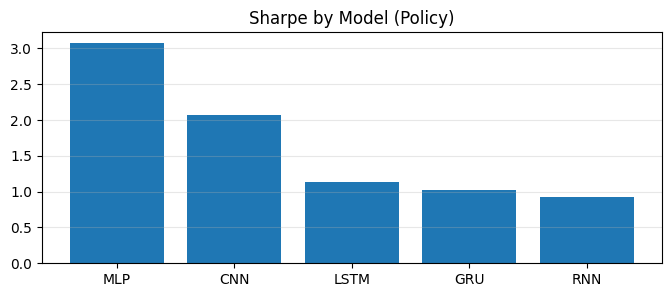


==== PLOTS for MLP ====


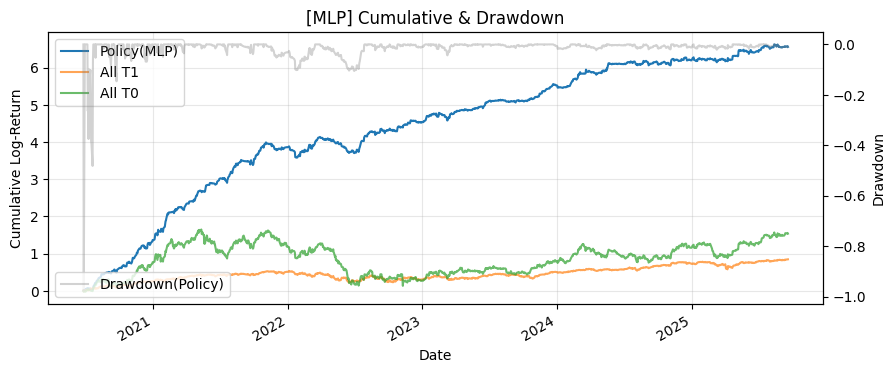

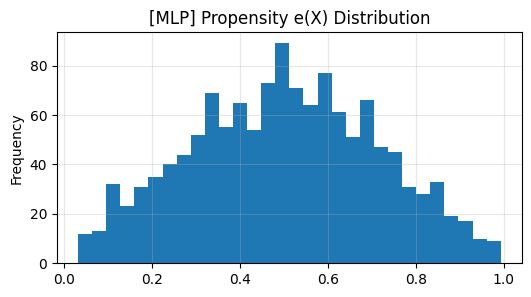

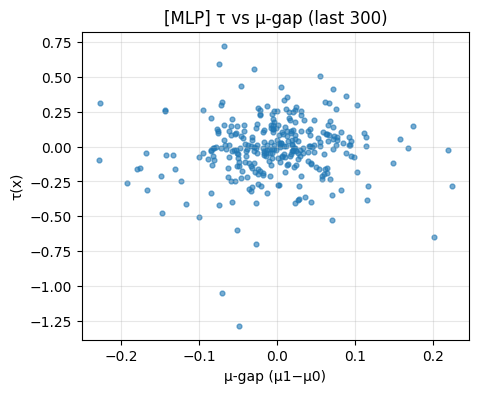


==== PLOTS for CNN ====


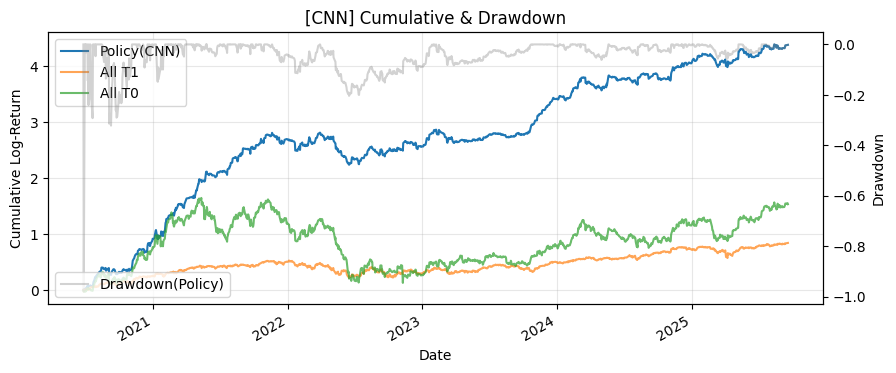

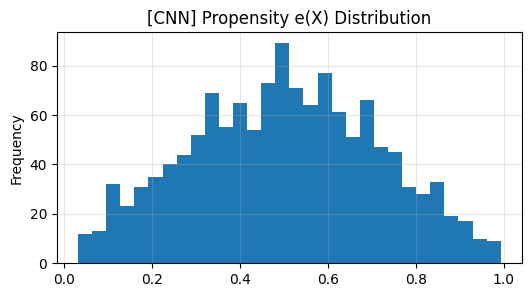

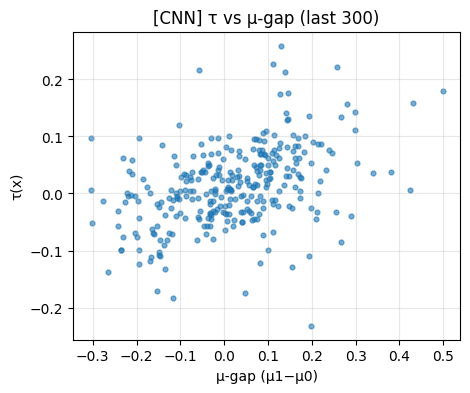


==== PLOTS for LSTM ====


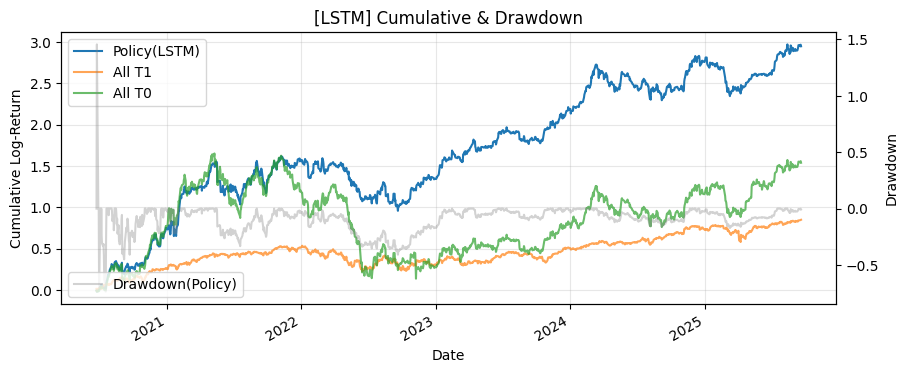

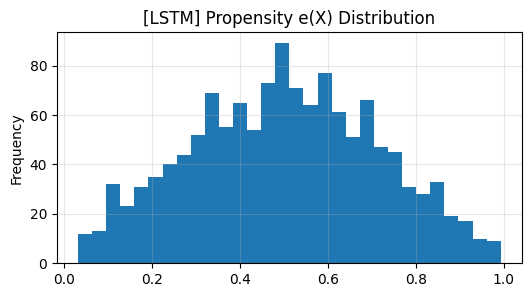

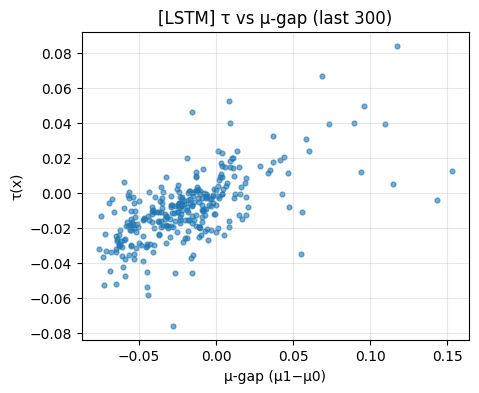


==== PLOTS for GRU ====


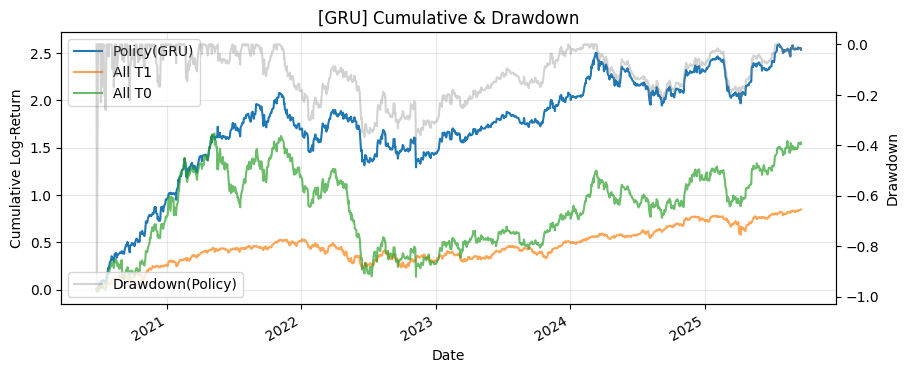

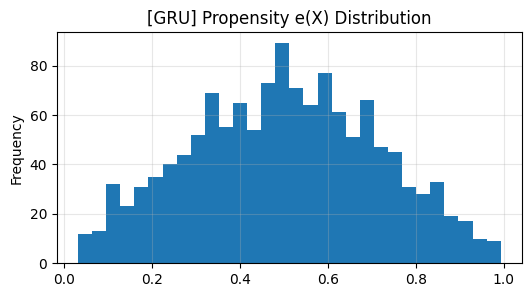

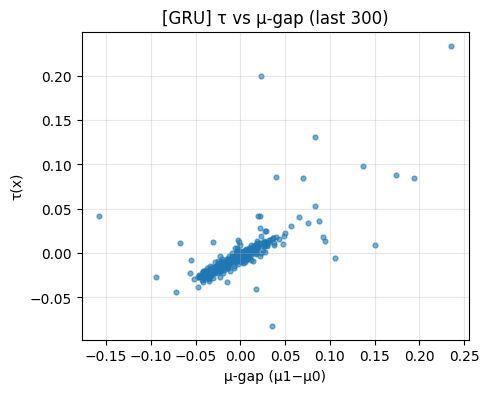


==== PLOTS for RNN ====


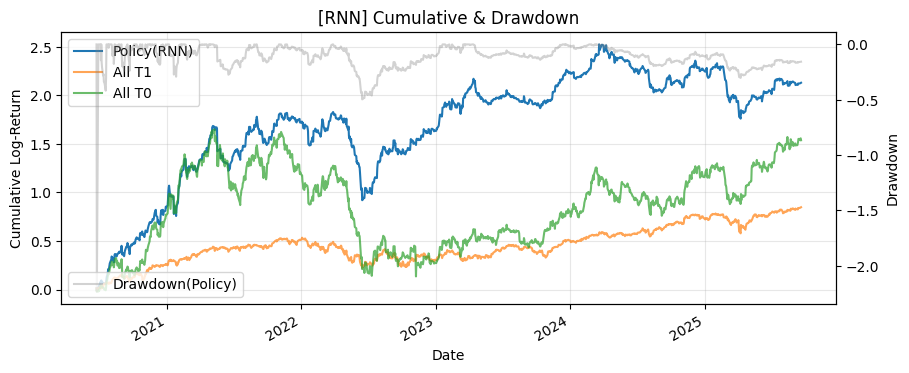

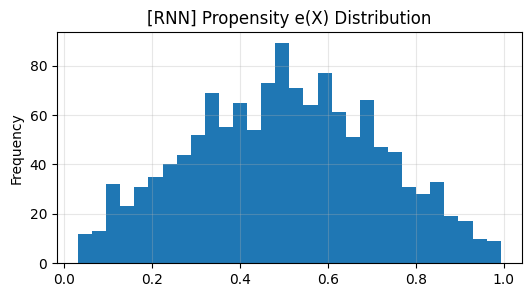

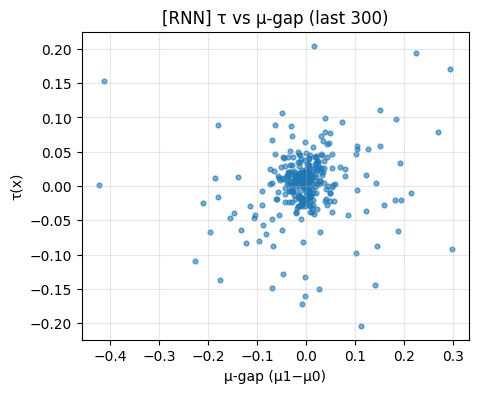

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 전체 비교 바차트 (Sharpe)
fig, ax = plt.subplots(figsize=(8,3))
order = results_df.sort_values("Sharpe(strat)", ascending=False)
ax.bar(order["kind"], order["Sharpe(strat)"])
ax.set_title("Sharpe by Model (Policy)")
ax.grid(True, axis="y", alpha=0.3)
plt.show()

def plot_for_kind(kind:str, comps:dict):
    """한 모델(kind)에 대해 누적+드로다운 / e(X) 분포 / τ vs μ-gap 플롯"""
    cum = comps["cum"]          # strat/all_t1/all_t0 누적 로그수익
    dd  = comps["dd"]           # strat 드로다운 시계열
    e   = comps["e"]            # 경향점수
    tau = comps["tau"]          # 최종 τ(x)
    mu_gap = comps["mu_gap"]    # μ1-μ0

    # (a) 누적 로그수익 + 드로다운(2축)
    fig, ax1 = plt.subplots(figsize=(10,4))
    cum["strat"].plot(ax=ax1, label=f"Policy({kind})")
    cum["all_t1"].plot(ax=ax1, label="All T1", alpha=0.7)
    cum["all_t0"].plot(ax=ax1, label="All T0", alpha=0.7)
    ax1.set_ylabel("Cumulative Log-Return"); ax1.grid(True, alpha=0.3); ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    dd.plot(ax=ax2, color="gray", alpha=0.35, label="Drawdown(Policy)")
    ax2.set_ylabel("Drawdown"); ax2.legend(loc="lower left")
    ax1.set_title(f"[{kind}] Cumulative & Drawdown")
    plt.show()

    # (b) e(X) 분포
    fig, ax = plt.subplots(figsize=(6,3))
    e.plot(kind="hist", bins=30, ax=ax)
    ax.set_title(f"[{kind}] Propensity e(X) Distribution")
    ax.grid(True, alpha=0.3)
    plt.show()

    # (c) τ vs μ-gap 산점도 (최근 300개)
    tmp = pd.concat([mu_gap, tau], axis=1).dropna().tail(300)
    tmp.columns = ["mu_gap", "tau"]
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(tmp["mu_gap"], tmp["tau"], s=12, alpha=0.6)
    ax.set_xlabel("μ-gap (μ1−μ0)"); ax.set_ylabel("τ(x)")
    ax.set_title(f"[{kind}] τ vs μ-gap (last 300)")
    ax.grid(True, alpha=0.3)
    plt.show()

# 모델별 전부 출력 (Sharpe 높은 순으로)
for kind in order["kind"].tolist():
    print(f"\n==== PLOTS for {kind} ====")
    plot_for_kind(kind, comps_map[kind])


## 7-5) 성능이 가장좋은것 선택 1

=== RUN MLP ===
=== RUN LSTM ===
=== RUN GRU ===
=== RUN CNN ===
=== RUN RNN ===


,kind,mu_used(mu1),mu_used(mu0),tau_used(tau1),tau_used(tau0),corr(mu1),corr(mu0),rmse_avg,mean_e,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat),"corr(tau, mu_gap)"
0,MLP,MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),-0.042321,0.102508,0.242539,0.501065,3.070696,0.879696,0.493043,-0.980659,0.391901
3,CNN,CNN,CNN,CNN,CNN,0.012814,0.142214,0.115282,0.501065,2.129164,0.879696,0.493043,-0.805173,0.364576
2,GRU,GRU,GRU,GRU,GRU,-0.131309,0.005254,0.066237,0.501065,1.694935,0.879696,0.493043,-0.813577,0.742025
4,RNN,RNN,RNN,RNN,RNN,0.119054,0.091943,0.083351,0.501065,1.051881,0.879696,0.493043,-2.234115,0.214201
1,LSTM,LSTM,LSTM,LSTM,LSTM,-0.044611,0.005657,0.067257,0.501065,0.638156,0.879696,0.493043,-2.234115,0.753734


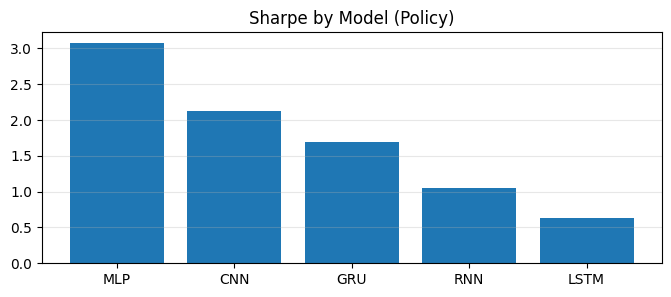

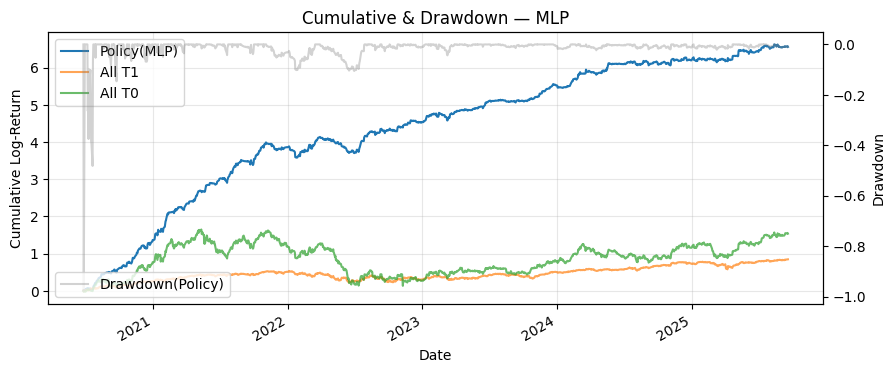

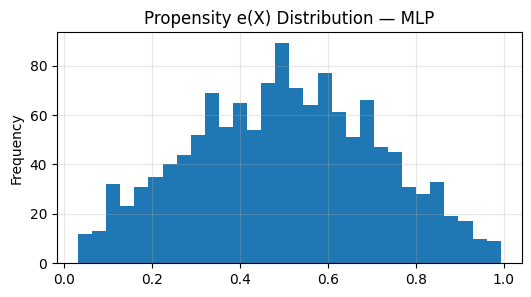

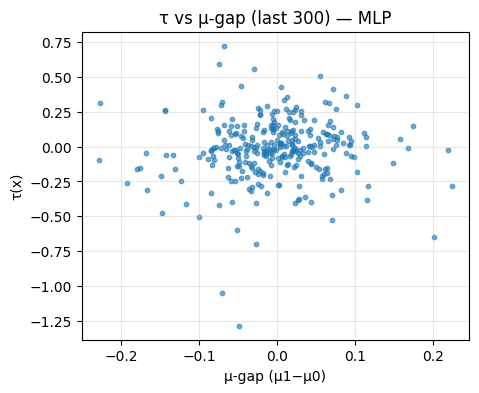

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) 모델 스윕 (결과표 + best 모델 자동 선택)
MODEL_LIST = ["MLP","LSTM","GRU","CNN","RNN"]
results, comps_map = [], {}
for kind in MODEL_LIST:
    print(f"=== RUN {kind} ===")
    m, comps = run_one(kind, CFG, X, y1, y0, data, return_components=True)
    results.append(m)
    comps_map[kind] = comps

results_df = pd.DataFrame(results)
display(results_df.sort_values("Sharpe(strat)", ascending=False))

# 2) Sharpe 바차트
fig, ax = plt.subplots(figsize=(8,3))
order = results_df.sort_values("Sharpe(strat)", ascending=False)
ax.bar(order["kind"], order["Sharpe(strat)"])
ax.set_title("Sharpe by Model (Policy)"); ax.grid(True, axis="y", alpha=0.3)
plt.show()

# 3) 상세 플롯: 상위 1개 모델(원하면 KIND_TO_PLOT='LSTM' 처럼 지정)
BEST_KIND = order.iloc[0]["kind"]
KIND_TO_PLOT = BEST_KIND  # <- 바꾸면 다른 모델 플로팅
c = comps_map[KIND_TO_PLOT]
cum = c["cum"]; dd = c["dd"]; e = c["e"]; tau = c["tau"]; mu_gap = c["mu_gap"]

# (a) 누적 로그수익 + 드로다운(2축)
fig, ax1 = plt.subplots(figsize=(10,4))
cum["strat"].plot(ax=ax1, label=f"Policy({KIND_TO_PLOT})")
cum["all_t1"].plot(ax=ax1, label="All T1", alpha=0.7)
cum["all_t0"].plot(ax=ax1, label="All T0", alpha=0.7)
ax1.set_ylabel("Cumulative Log-Return"); ax1.grid(True, alpha=0.3); ax1.legend(loc="upper left")

ax2 = ax1.twinx()
dd.plot(ax=ax2, color="gray", alpha=0.35, label="Drawdown(Policy)")
ax2.set_ylabel("Drawdown"); ax2.legend(loc="lower left")
ax1.set_title(f"Cumulative & Drawdown — {KIND_TO_PLOT}")
plt.show()

# (b) e(X) 분포 히스토그램
fig, ax = plt.subplots(figsize=(6,3))
e.plot(kind="hist", bins=30, ax=ax)
ax.set_title(f"Propensity e(X) Distribution — {KIND_TO_PLOT}")
ax.grid(True, alpha=0.3)
plt.show()

# (c) τ vs μ-갭 산점도 (최근 300개)
fig, ax = plt.subplots(figsize=(5,4))
tmp = pd.concat([tau, mu_gap], axis=1).dropna().tail(300)
ax.scatter(tmp["mu1"] if "mu1" in tmp.columns else tmp.iloc[:,1],
           tmp["tau"], s=10, alpha=0.6)
ax.set_xlabel("μ-gap (μ1−μ0)"); ax.set_ylabel("τ(x)")
ax.set_title(f"τ vs μ-gap (last 300) — {KIND_TO_PLOT}")
ax.grid(True, alpha=0.3)
plt.show()


# 8) 딥러닝 모델 확장 (평가메트릭 추가)

## 8-1) 평가메트릭 함수/유틸 정의

In [ ]:
# ===========================
# 평가 메트릭 & 통계검정 유틸
# ===========================
import numpy as np
import pandas as pd
from math import sqrt
from scipy.stats import t as student_t
import warnings

# ---------- 1) 위험조정 성과 ----------
def sharpe_ratio(r, ann=252):
    r = pd.Series(r).dropna()
    s = r.std()
    return (r.mean() / s * np.sqrt(ann)) if s and np.isfinite(s) else np.nan

def sortino_ratio(r, mar=0.0, ann=252):
    r = pd.Series(r).dropna()
    downside = r[r < mar] - mar
    dd = downside.std()
    return ((r.mean() - mar) / dd * np.sqrt(ann)) if dd and np.isfinite(dd) else np.nan

def calmar_ratio(r, ann=252):
    r = pd.Series(r).dropna()
    cum = r.cumsum()
    peak = cum.cummax()
    dd = (cum - peak)
    mdd = dd.min()  # log-return 누적 기준(음수)
    cagr = r.mean() * ann
    return (cagr / abs(mdd)) if (mdd < 0) else np.nan

def omega_ratio(r, mar=0.0, grid=200):
    """연속 근사 Omega: ∫_{mar}^∞ (1 - F(r)) dr / ∫_{-∞}^{mar} F(r) dr"""
    r = pd.Series(r).dropna()
    if r.empty: return np.nan
    qs = np.linspace(r.min(), r.max(), grid)
    ecdf = lambda x: (r <= x).mean()
    surv = lambda x: 1.0 - ecdf(x)
    num = np.trapz([surv(q) for q in qs if q >= mar], qs[qs >= mar]) if (qs >= mar).any() else np.nan
    den = np.trapz([ecdf(q) for q in qs if q <= mar], qs[qs <= mar]) if (qs <= mar).any() else np.nan
    return (num / den) if (num and den and den > 0) else np.nan

def max_drawdown(r):
    cum = pd.Series(r).dropna().cumsum()
    peak = cum.cummax()
    dd = cum - peak
    return dd.min()

# ---------- 2) Diebold–Mariano 테스트 ----------
def dm_test(y_true, yhat_1, yhat_2, h=1, power=2, lag=None):
    """
    DM test for forecast accuracy difference.
    y_true, yhat_1, yhat_2: 1D array-like (동일 길이)
    h: forecast horizon
    power: 1(absolute), 2(squared) loss
    lag: HAC(Newey-West) lag; None이면 ≈ h-1 로 기본
    """
    y_true = pd.Series(y_true).astype(float)
    e1 = y_true - pd.Series(yhat_1).astype(float)
    e2 = y_true - pd.Series(yhat_2).astype(float)
    if power == 1:
        d = np.abs(e1) - np.abs(e2)
    elif power == 2:
        d = (e1**2) - (e2**2)
    else:
        raise ValueError("power must be 1 or 2")

    d = d.dropna()
    T = len(d)
    if T < 10:
        raise ValueError("Not enough data points for DM test")

    # Newey-West HAC variance
    if lag is None:
        lag = max(h - 1, 0)
    d_mean = d.mean()
    gamma0 = np.var(d, ddof=0)
    cov = gamma0
    for l in range(1, lag + 1):
        w = 1.0 - l / (lag + 1)
        gamma = np.cov(d[l:], d[:-l], ddof=0)[0, 1]
        cov += 2 * w * gamma
    var = cov / T
    dm_stat = d_mean / np.sqrt(var) if var > 0 else np.nan
    # DM 통계량 ~ t_{T-1} 근사
    p_value = 2 * (1 - student_t.cdf(abs(dm_stat), df=T - 1)) if np.isfinite(dm_stat) else np.nan
    return dm_stat, p_value, T

# ---------- 3) τ(x) 블록 부트스트랩 ----------
def block_bootstrap_tau(tau_series: pd.Series, block=20, B=1000, agg="mean", random_state=42):
    """
    시계열 의존성 보존을 위해 block bootstrap.
    - block: 블록 길이(영업일 기준)
    - B: 부트스트랩 반복 수
    - agg: "mean" 또는 "median"
    반환: {'est': 원추정치, 'ci': (lo, hi), 'samples': np.array}
    """
    rng = np.random.default_rng(random_state)
    tau = pd.Series(tau_series).dropna().values
    n = len(tau)
    if n == 0:
        return {"est": np.nan, "ci": (np.nan, np.nan), "samples": np.array([])}
    k = int(np.ceil(n / block))  # 블록 개수

    def _agg(x):
        x = np.asarray(x)
        return np.nanmean(x) if agg == "mean" else np.nanmedian(x)

    est = _agg(tau)
    boots = np.empty(B)
    for b in range(B):
        idx = []
        for _ in range(k):
            start = rng.integers(0, max(n - block + 1, 1))
            idx.extend(range(start, min(start + block, n)))
        idx = idx[:n]
        boots[b] = _agg(tau[idx])

    lo, hi = np.nanpercentile(boots, [2.5, 97.5])
    return {"est": est, "ci": (lo, hi), "samples": boots}

# ---------- 4) 레짐 분할(옵션) ----------
def regime_split_perf(r, vix=None, dgs10=None, vix_q=0.5, dgs10_diff=False, ann=252):
    """
    r: 수익률 Series
    vix: 레벨 Series(같은 인덱스)
    dgs10: 금리 레벨 Series(같은 인덱스)
    vix_q: VIX quantile 경계(0~1)
    dgs10_diff: True면 금리 '상승기'(1차차분>0)/'하락기' 분할
    """
    out = {}
    r = pd.Series(r).dropna()
    if vix is not None and not pd.Series(vix).dropna().empty:
        vix = pd.Series(vix).reindex(r.index).ffill()
        thr = vix.quantile(vix_q)
        low = r[vix <= thr]; high = r[vix > thr]
        out["VIX_low"]  = {"Sharpe": sharpe_ratio(low, ann),  "Sortino": sortino_ratio(low, ann=ann)}
        out["VIX_high"] = {"Sharpe": sharpe_ratio(high, ann), "Sortino": sortino_ratio(high, ann=ann)}
    if dgs10 is not None and not pd.Series(dgs10).dropna().empty:
        g = pd.Series(dgs10).reindex(r.index).ffill()
        if dgs10_diff:
            up = r[g.diff().fillna(0) > 0]
            dn = r[g.diff().fillna(0) <= 0]
            out["DGS10_up"] = {"Sharpe": sharpe_ratio(up, ann), "Sortino": sortino_ratio(up, ann=ann)}
            out["DGS10_dn"] = {"Sharpe": sharpe_ratio(dn, ann), "Sortino": sortino_ratio(dn, ann=ann)}
    return pd.DataFrame(out).T if out else pd.DataFrame()

# ===========================
#  실행: 현재 세션 변수 활용
# ===========================
print("== 성과지표 계산 ==")
if "df" in globals():
    # df: ['strat','all_t1','all_t0'] 가정 (log-returns)
    r = globals()["df"]
    res = []
    for name in ["strat","all_t1","all_t0"]:
        if name in r:
            rr = r[name].dropna()
            res.append([
                name,
                sharpe_ratio(rr),
                sortino_ratio(rr),
                calmar_ratio(rr),
                omega_ratio(rr),
                max_drawdown(rr)
            ])
    perf = pd.DataFrame(res, columns=["series","Sharpe","Sortino","Calmar","Omega","MDD"])
    display(perf.style.format({"Sharpe":"{:.3f}","Sortino":"{:.3f}","Calmar":"{:.3f}","Omega":"{:.3f}","MDD":"{:.3f}"}))
else:
    warnings.warn("df (strat/all_t1/all_t0)가 없어 성과지표 표시는 생략합니다.")
    perf = pd.DataFrame()

print("\n== DM 테스트 (μ-모델 비교) ==")
if all(k in globals() for k in ["y1_te","X1_te","mu1","y0_te","X0_te","mu0"]):
    # 예시: 같은 목적(Y1)에 대해 모델1 vs 모델2 비교를 하려면, 두 예측을 준비하세요.
    # 여기서는 간단히 'mu1 vs mu0'을 각각 자신 타깃에 대해 비교 예시로 보여줍니다.
    # (연구에서는 동일 타깃에 대한 두 예측모델 비교로 맞추세요)
    try:
        # 같은 y1_te에 대해 임의로 두 예측을 만들고 비교(데모)
        y_true = pd.Series(y1_te)
        yhat_a = pd.Series(mu1.predict(X1_te), index=y_true.index)
        # 비교용 더 단순한 벤치마크: 이동평균(윈도우 5)로 구성
        yhat_b = y_true.shift(1).rolling(5).mean().bfill()
        dm_stat, pval, T = dm_test(y_true, yhat_a, yhat_b, h=1, power=2, lag=None)
        print(f"DM test vs (moving-average bench): stat={dm_stat:.3f}, p={pval:.4f}, T={T}")
    except Exception as e:
        warnings.warn(f"DM test 실패: {e}")
else:
    warnings.warn("DM test에 필요한 (y*_te, X*_te, mu*) 변수가 없어 건너뜁니다.")

print("\n== τ(x) 부트스트랩 신뢰구간 ==")
if "tau_final" in globals():
    boot = block_bootstrap_tau(globals()["tau_final"], block=20, B=1000, agg="mean", random_state=42)
    est, (lo, hi) = boot["est"], boot["ci"]
    print(f"tau mean: {est:.5f} | 95% CI: [{lo:.5f}, {hi:.5f}] (block=20, B=1000)")
else:
    warnings.warn("tau_final 변수가 없어 τ 부트스트랩을 건너뜁니다.")

print("\n== 레짐별 성과 (옵션) ==")
# vix/dgs10 이 Tab0에서 ctx['data']로 저장되어 있었다면 r.index에 맞춰 넣어 사용 가능
if "df" in globals():
    # 아래 변수들이 있으면 자동 사용
    vix = globals().get("vix", None)
    dgs10 = globals().get("dgs10", None)
    # 또는 ctx 구조를 쓰는 경우:
    try:
        if "data" in globals().get("ctx", {}):
            vix = globals()["ctx"]["data"].get("vix", vix)
            dgs10 = globals()["ctx"]["data"].get("dgs10", dgs10)
    except Exception:
        pass
    if vix is None and "data" in globals():
        vix = globals()["data"].get("vix", None) if isinstance(globals()["data"], dict) else None
    if dgs10 is None and "data" in globals():
        dgs10 = globals()["data"].get("dgs10", None) if isinstance(globals()["data"], dict) else None

    if "strat" in df:
        regime_tbl = regime_split_perf(df["strat"], vix=vix, dgs10=dgs10, vix_q=0.5, dgs10_diff=True)
        if not regime_tbl.empty:
            display(regime_tbl.style.format("{:.3f}").set_caption("Regime-wise Performance for 'strat'"))
        else:
            print("레짐 참조지표(VIX/DGS10)가 없어 레짐 테이블은 건너뜁니다.")
else:
    print("df 미존재로 레짐 분석 생략.")


== 성과지표 계산 ==


/tmp/ipython-input-3617418841.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num = np.trapz([surv(q) for q in qs if q >= mar], qs[qs >= mar]) if (qs >= mar).any() else np.nan
/tmp/ipython-input-3617418841.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  den = np.trapz([ecdf(q) for q in qs if q <= mar], qs[qs <= mar]) if (qs <= mar).any() else np.nan


,series,Sharpe,Sortino,Calmar,Omega,MDD
0,strat,3.104,5.709,3.180,1.868,-0.404
1,all_t1,0.914,1.271,0.587,1.105,-0.309
2,all_t0,0.632,0.856,0.249,1.043,-1.514



== DM 테스트 (μ-모델 비교) ==
DM test vs (moving-average bench): stat=6.428, p=0.0000, T=274

== τ(x) 부트스트랩 신뢰구간 ==
tau mean: -0.00352 | 95% CI: [-0.01177, 0.00499] (block=20, B=1000)

== 레짐별 성과 (옵션) ==
레짐 참조지표(VIX/DGS10)가 없어 레짐 테이블은 건너뜁니다.


## 8-2) 딥러닝 평가 함수

In [ ]:
# === REPLACE: run_one (확장판, 평가 지표 풀세트) ===
def run_one(kind:str, CFG, X, y1, y0, data, return_components: bool=False):
    import numpy as np, pandas as pd
    from sklearn.metrics import (
        root_mean_squared_error, mean_absolute_error, r2_score,
        roc_auc_score, log_loss, brier_score_loss
    )
    from sklearn.linear_model import LogisticRegression

    ANN = 252
    EPS = 1e-12

    # ---------- 공용 유틸 ----------
    def _align_xy(X, y):
        comb = pd.concat([X, y], axis=1).dropna()
        return comb.iloc[:,:-1], comb.iloc[:,-1]

    def _split(X, y, test_ratio=0.2):
        n = len(X); n_tr = int(n * (1 - test_ratio))
        return X.iloc[:n_tr], X.iloc[n_tr:], y.iloc[:n_tr], y.iloc[n_tr:]

    def sharpe(r):
        s = r.std(ddof=1)
        return (r.mean()/s*np.sqrt(ANN)) if s > 0 else np.nan

    def downside_dev(r, mar=0.0):
        x = r - mar/ANN
        dn = np.minimum(x, 0.0)
        return float(np.sqrt((dn**2).mean()))

    def sortino(r, mar=0.0):
        dd = downside_dev(r, mar)
        return (r.mean()*ANN - mar) / (dd*np.sqrt(ANN)) if dd > 0 else np.nan

    def drawdown_path(cum):
        peak = cum.cummax()
        return cum/peak - 1.0

    def max_drawdown(r):
        return float(drawdown_path(r.cumsum()).min())

    def drawdown_stats(r):
        dd = drawdown_path(r.cumsum())
        mdd = float(dd.min())
        neg = (dd < 0).astype(int)
        run_lengths = (neg*(neg.groupby((neg!=neg.shift()).cumsum()).cumcount()+1))
        max_dur = int(run_lengths.max()) if len(run_lengths) else 0
        return mdd, max_dur, float(dd.mean())

    def ann_return(r):
        return float(np.exp(r.sum()) - 1.0)

    def ann_vol(r):
        return float(r.std(ddof=1) * np.sqrt(ANN))

    def calmar(r):
        ar = ann_return(r); mdd = abs(max_drawdown(r))
        return (ar/mdd) if mdd > 0 else np.nan

    def omega_ratio(r, threshold=0.0):
        x = r - threshold/ANN
        pos = x[x>0].sum()
        neg = (-x[x<0]).sum()
        return float(pos/neg) if neg > 0 else np.nan

    def information_ratio(r, bench):
        diff = r - bench
        s = diff.std(ddof=1)
        return (diff.mean()/s*np.sqrt(ANN)) if s>0 else np.nan

    def turnover(pos):
        p = pos.astype(float).fillna(0.0)
        return float(p.diff().abs().fillna(0.0).mean())

    def apply_costs(r, pos, cost_bps=5.0):
        tw = pos.astype(float).diff().abs().fillna(0.0)
        return r - (cost_bps/10000.0)*tw

    def var_cvar(r, alpha=0.95):
        q = float(np.quantile(r, 1.0-alpha))
        cvar = float(r[r<=q].mean()) if (r<=q).any() else q
        return q, cvar

    def skew_kurt(r):
        s = pd.Series(r)
        return float(s.skew()), float(s.kurt())

    def bootstrap_ci(series, stat_fn, B=500, alpha=0.95, block=5):
        x = pd.Series(series).dropna().values
        n = len(x)
        if n == 0: return (np.nan, np.nan, np.nan)
        stats = []
        for _ in range(B):
            idx = []
            while len(idx) < n:
                st = np.random.randint(0, max(1, n - block + 1))
                idx.extend(range(st, min(st+block, n)))
            idx = idx[:n]
            stats.append(stat_fn(pd.Series(x[idx])))
        lo, hi = np.quantile(stats, [(1-alpha)/2, 1-(1-alpha)/2])
        return (float(np.mean(stats)), float(lo), float(hi))

    # ---------- ① μ 학습 ----------
    win = CFG["seq_window"]
    X1, y1a = _align_xy(X, y1); X0, y0a = _align_xy(X, y0)
    n = min(len(X1), len(X0))
    X1, y1a = X1.iloc[:n], y1a.iloc[:n]
    X0, y0a = X0.iloc[:n], y0a.iloc[:n]
    X1_tr, X1_te, y1_tr, y1_te = _split(X1, y1a)
    X0_tr, X0_te, y0_tr, y0_te = _split(X0, y0a)

    mu1 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    mu0 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    used_mu1 = f"{kind}" + ("(fallback→MLP)" if hasattr(mu1, "_fallback_from") else "")
    used_mu0 = f"{kind}" + ("(fallback→MLP)" if hasattr(mu0, "_fallback_from") else "")
    mu1.fit(X1_tr, y1_tr); mu0.fit(X0_tr, y0_tr)

    mu1_full = pd.Series(mu1.predict(X), index=X.index, name="mu1")
    mu0_full = pd.Series(mu0.predict(X), index=X.index, name="mu0")

    p1_te = pd.Series(mu1.predict(X1_te), index=X1_te.index)
    p0_te = pd.Series(mu0.predict(X0_te), index=X0_te.index)
    corr1 = p1_te.corr(y1_te); corr0 = p0_te.corr(y0_te)
    rmse1 = root_mean_squared_error(y1_te, p1_te)
    rmse0 = root_mean_squared_error(y0_te, p0_te)
    rmse_avg = (rmse1 + rmse0) / 2
    # 추가 회귀 지표
    mae1 = mean_absolute_error(y1_te, p1_te)
    mae0 = mean_absolute_error(y0_te, p0_te)
    r2_1 = r2_score(y1_te, p1_te)
    r2_0 = r2_score(y0_te, p0_te)
    qlike1 = float(((y1_te - p1_te)**2 / np.maximum(EPS, p1_te**2)).mean())
    qlike0 = float(((y0_te - p0_te)**2 / np.maximum(EPS, p0_te**2)).mean())

    # ---------- ② CF / τ / e ----------
    r1 = data["ret_T1"].reindex(X.index)
    r0 = data["ret_T0"].reindex(X.index)
    D1 = (r1 - mu0_full).rename("D1")
    D0 = (mu1_full - r0).rename("D0")

    X1b, y1b = _align_xy(X, D1); X0b, y0b = _align_xy(X, D0)
    n2 = min(len(X1b), len(X0b))
    X1b, y1b = X1b.iloc[:n2], y1b.iloc[:n2]
    X0b, y0b = X0b.iloc[:n2], y0b.iloc[:n2]
    X1_tr2, X1_te2, y1_tr2, y1_te2 = _split(X1b, y1b)
    X0_tr2, X0_te2, y0_tr2, y0_te2 = _split(X0b, y0b)

    tau1 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    tau0 = get_regressor(kind, window=win, lr=1e-3, epochs=20, batch=64)
    used_tau1 = f"{kind}" + ("(fallback→MLP)" if hasattr(tau1, "_fallback_from") else "")
    used_tau0 = f"{kind}" + ("(fallback→MLP)" if hasattr(tau0, "_fallback_from") else "")
    tau1.fit(X1_tr2, y1_tr2); tau0.fit(X0_tr2, y0_tr2)

    tau1_full = pd.Series(tau1.predict(X), index=X.index, name="tau1")
    tau0_full = pd.Series(tau0.predict(X), index=X.index, name="tau0")

    label = (r1 > r0).astype(int)
    Xc, yl = _align_xy(X, label)
    Xc_tr, Xc_te, yl_tr, yl_te = _split(Xc, yl)
    clf = LogisticRegression(max_iter=200)
    clf.fit(Xc_tr, yl_tr)
    proba = pd.Series(clf.predict_proba(X)[:,1], index=X.index, name="e")

    tau_final = (proba * tau0_full + (1.0 - proba) * tau1_full).rename("tau")

    # e(X) 분류/캘리브레이션 지표
    yl_te_hat = pd.Series(clf.predict_proba(Xc_te)[:,1], index=Xc_te.index)
    try:
        auc = float(roc_auc_score(yl_te, yl_te_hat))
    except ValueError:
        auc = np.nan
    ll  = float(log_loss(yl_te, yl_te_hat.clip(EPS, 1-EPS)))
    brier = float(brier_score_loss(yl_te, yl_te_hat))
    # 간단 ECE
    dfc = pd.DataFrame({"y":yl_te.values, "p":yl_te_hat.values})
    if len(dfc) >= 10:
        dfc["bin"] = pd.qcut(dfc["p"], q=10, duplicates="drop")
        calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))
        ece = float((calib["p_hat"]-calib["y_bar"]).abs().mean())
    else:
        calib = pd.DataFrame(columns=["p_hat","y_bar"])
        ece = np.nan

    # ---------- ③ 정책 ----------
    pick_T1 = (tau_final > 0).astype(int)
    strat = (pick_T1*r1 + (1-pick_T1)*r0).rename("strat")
    all_t1, all_t0 = r1.rename("all_t1"), r0.rename("all_t0")
    df = pd.concat([strat, all_t1, all_t0], axis=1).dropna()
    cum = df.cumsum()

    sharpe_strat = sharpe(df["strat"])
    sharpe_t1    = sharpe(df["all_t1"])
    sharpe_t0    = sharpe(df["all_t0"])
    mdd_strat    = max_drawdown(df["strat"])
    mdd, mdd_dur, avg_dd = drawdown_stats(df["strat"])

    # 비용/턴오버, 순성과
    to_day = turnover(pick_T1.reindex(df.index))
    r_net  = apply_costs(df["strat"], pick_T1.reindex(df.index), cost_bps=5.0)

    # 리스크/성과 확장
    var95, cvar95 = var_cvar(df["strat"], alpha=0.95)
    sk, ku = skew_kurt(df["strat"])
    calmar_v = calmar(df["strat"])
    sortino_v = sortino(df["strat"])
    ir_t1 = information_ratio(df["strat"], df["all_t1"])
    ir_t0 = information_ratio(df["strat"], df["all_t0"])

    # 부트스트랩 CI (Sharpe)
    sh_mean, sh_lo, sh_hi = bootstrap_ci(df["strat"], sharpe, B=500, alpha=0.95, block=5)

    # τ 내부정합
    mu_gap = (mu1_full - mu0_full).reindex(tau_final.index)
    corr_tau_muGap = float(tau_final.corr(mu_gap)) if mu_gap.notna().any() else np.nan

    # ---------- 메트릭 dict ----------
    metrics = {
        "kind": kind,
        "mu_used(mu1)": used_mu1,
        "mu_used(mu0)": used_mu0,
        "tau_used(tau1)": used_tau1,
        "tau_used(tau0)": used_tau0,

        # μ 품질
        "corr(mu1)": float(corr1) if pd.notna(corr1) else np.nan,
        "corr(mu0)": float(corr0) if pd.notna(corr0) else np.nan,
        "rmse_avg": float(rmse_avg),
        "mae(mu1)": float(mae1), "mae(mu0)": float(mae0),
        "r2(mu1)": float(r2_1),   "r2(mu0)": float(r2_0),
        "qlike(mu1)": float(qlike1), "qlike(mu0)": float(qlike0),

        # e(X) 품질
        "mean_e": float(proba.mean()),
        "AUC(e)": float(auc), "LogLoss(e)": float(ll),
        "Brier(e)": float(brier), "ECE(e)": float(ece),

        # 전략 성과/리스크
        "Sharpe(strat)": float(sharpe_strat),
        "Sharpe(T1)": float(sharpe_t1),
        "Sharpe(T0)": float(sharpe_t0),
        "Sortino(strat)": float(sortino_v),
        "AnnRet(strat)": float(ann_return(df["strat"])),
        "AnnVol(strat)": float(ann_vol(df["strat"])),
        "Calmar(strat)": float(calmar_v),
        "Omega(strat)": float(omega_ratio(df["strat"])),
        "InfoRatio(vs T1)": float(ir_t1),
        "InfoRatio(vs T0)": float(ir_t0),
        "VaR95(strat)": float(var95),
        "CVaR95(strat)": float(cvar95),
        "Skew(strat)": float(sk),
        "Kurt(strat)": float(ku),

        "MDD(strat)": float(mdd),
        "MDD_Duration": int(mdd_dur),
        "AvgDrawdown": float(avg_dd),

        # 거래/비용
        "Turnover(daily)": float(to_day),
        "Sharpe_net(5bps)": float(sharpe(r_net)),
        "MDD_net(5bps)": float(max_drawdown(r_net)),

        # τ 내부 정합
        "corr(tau, mu_gap)": float(corr_tau_muGap),

        # Sharpe 부트스트랩 CI
        "Sharpe_bs_mean": float(sh_mean),
        "Sharpe_bs_lo": float(sh_lo),
        "Sharpe_bs_hi": float(sh_hi),
    }

    if return_components:
        comps = {
            "df": df,                  # strat, all_t1, all_t0
            "cum": cum,                # 누적(로그)
            "dd": drawdown_path(cum["strat"]),
            "e": proba,                # propensity
            "tau": tau_final,          # 최종 τ
            "mu_gap": mu_gap,          # μ1-μ0
            "calib_table": calib,      # e(X) 캘리브레이션 테이블(빈 가능)
            "r_net": r_net,            # 비용 반영 수익률
            "pos": pick_T1,            # 포지션(턴오버 계산용)
        }
        return metrics, comps

    return metrics


## 8-3) X-Learner 딥러닝 모델별 수행 (확장판)

In [ ]:
# 모델 스윕 실행: 각 모델의 메트릭과 플롯 컴포넌트를 모두 저장
results, comps_map = [], {}
for kind in MODEL_LIST:
    print(f"=== RUN {kind} ===")
    m, comps = run_one(kind, CFG, X, y1, y0, data, return_components=True)
    results.append(m)
    comps_map[kind] = comps

results_df = pd.DataFrame(results)
display(results_df.sort_values("Sharpe(strat)", ascending=False))

=== RUN MLP ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))


=== RUN LSTM ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))


=== RUN GRU ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))


=== RUN CNN ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))


=== RUN RNN ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))


,kind,mu_used(mu1),mu_used(mu0),tau_used(tau1),tau_used(tau0),corr(mu1),corr(mu0),rmse_avg,mae(mu1),mae(mu0),...,MDD(strat),MDD_Duration,AvgDrawdown,Turnover(daily),Sharpe_net(5bps),MDD_net(5bps),"corr(tau, mu_gap)",Sharpe_bs_mean,Sharpe_bs_lo,Sharpe_bs_hi
0,MLP,MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),-0.042321,0.102508,0.242539,0.169508,0.184294,...,-0.980659,90,-0.014738,0.313830,2.971206,-1.019537,0.391901,3.083032,2.236355,3.961682
3,CNN,CNN,CNN,CNN,CNN,0.020108,0.111849,0.121249,0.077557,0.113439,...,-0.287586,169,-0.025567,0.358663,2.063784,-0.300906,0.475069,2.172337,1.261684,3.091616
2,GRU,GRU,GRU,GRU,GRU,-0.173520,-0.045782,0.067615,0.030437,0.075797,...,-2.234115,525,-0.127382,0.193769,1.029312,-2.234115,0.811495,1.071285,0.176845,1.970166
4,RNN,RNN,RNN,RNN,RNN,-0.048865,0.056894,0.095289,0.058158,0.088366,...,-0.694369,842,-0.214482,0.310790,0.912259,-0.749407,0.302580,1.003494,0.045631,1.931627
1,LSTM,LSTM,LSTM,LSTM,LSTM,-0.054700,-0.049428,0.068560,0.032140,0.074962,...,-1.206425,969,-0.525480,0.281915,0.253048,-1.310977,0.604560,0.302062,-0.531886,1.128208


## 8-4) X-Learner 딥러닝 모델별 시각화(확장판)

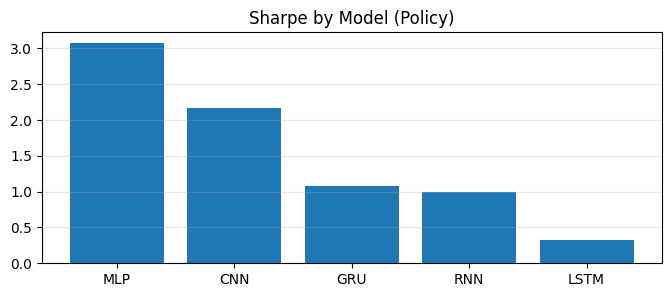


==== PLOTS for MLP ====


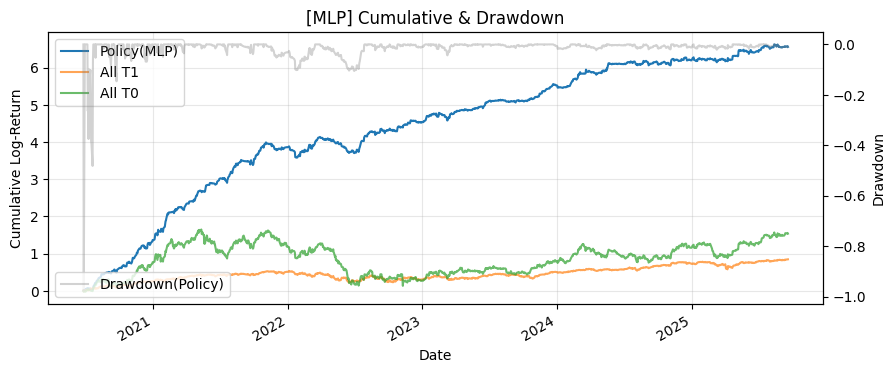

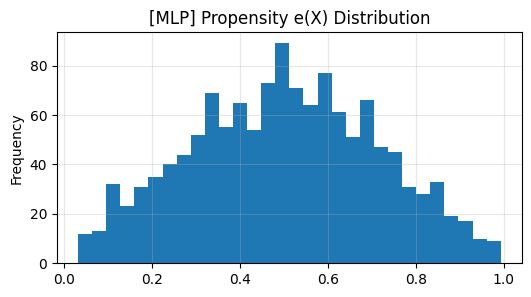

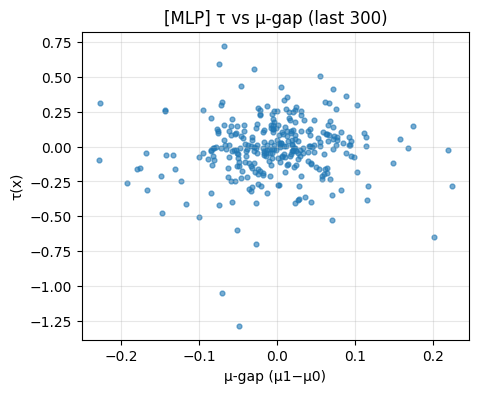


==== PLOTS for CNN ====


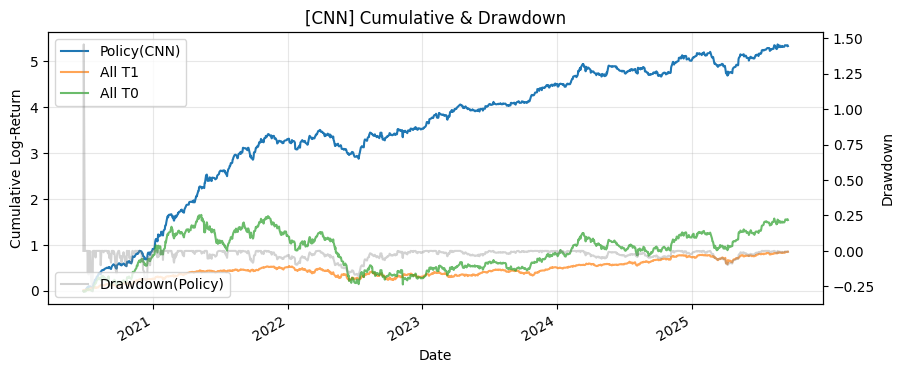

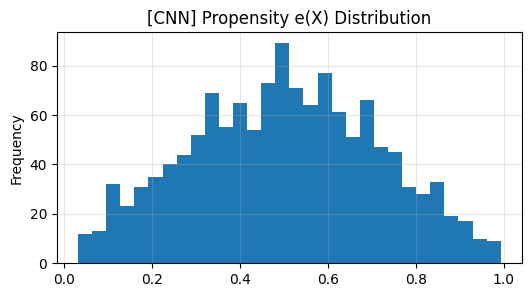

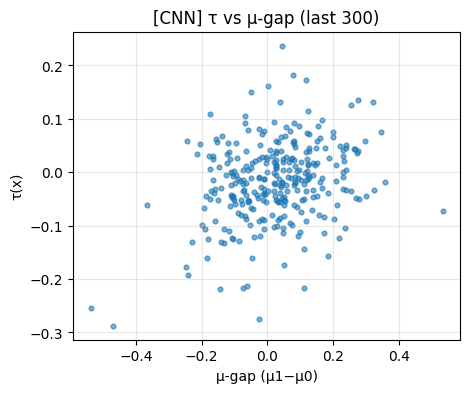


==== PLOTS for GRU ====


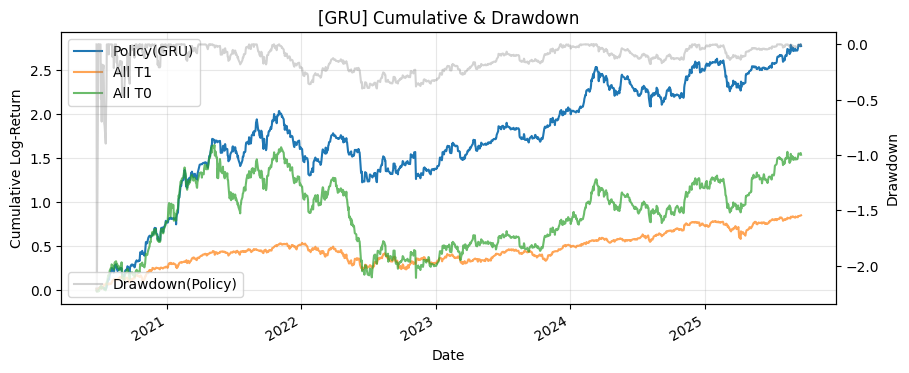

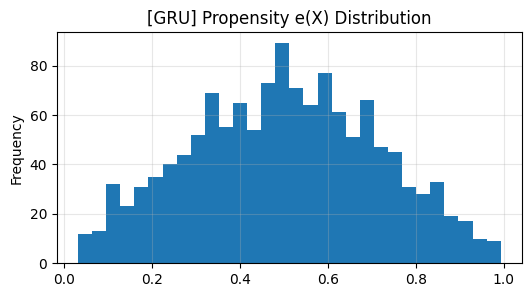

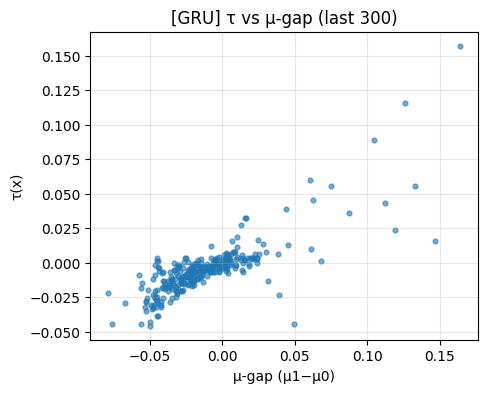


==== PLOTS for RNN ====


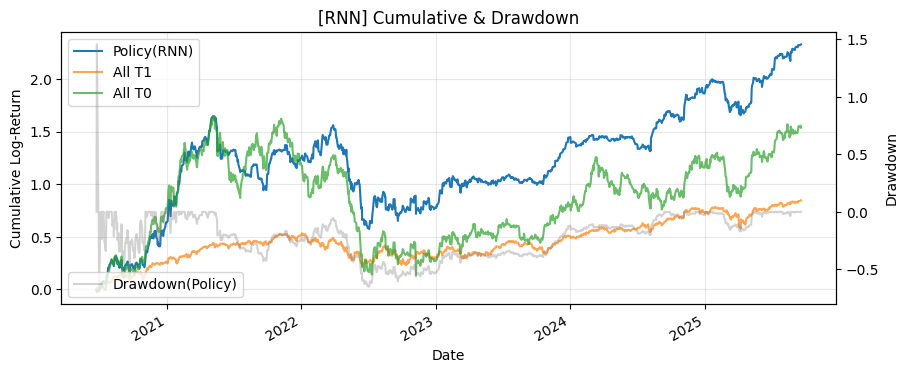

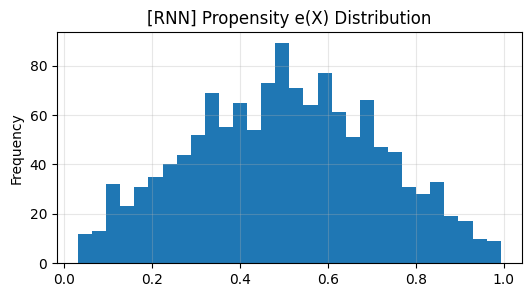

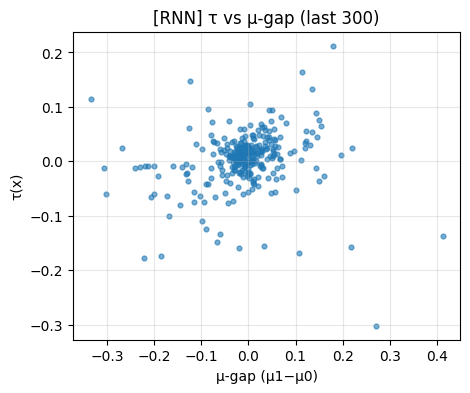


==== PLOTS for LSTM ====


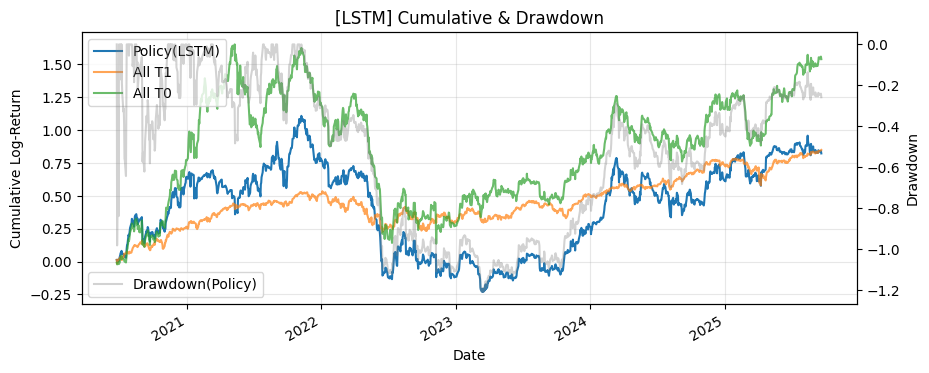

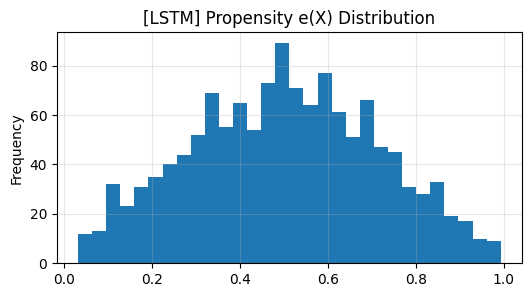

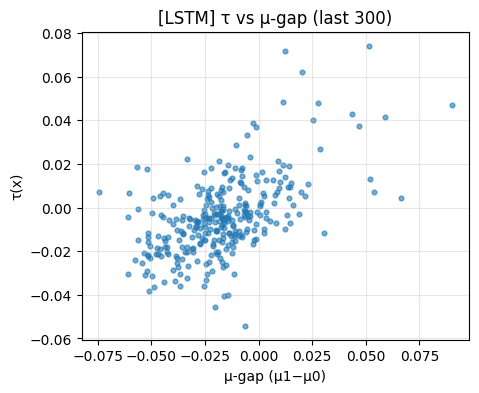

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 전체 비교 바차트 (Sharpe)
fig, ax = plt.subplots(figsize=(8,3))
order = results_df.sort_values("Sharpe(strat)", ascending=False)
ax.bar(order["kind"], order["Sharpe(strat)"])
ax.set_title("Sharpe by Model (Policy)")
ax.grid(True, axis="y", alpha=0.3)
plt.show()

def plot_for_kind(kind:str, comps:dict):
    """한 모델(kind)에 대해 누적+드로다운 / e(X) 분포 / τ vs μ-gap 플롯"""
    cum = comps["cum"]          # strat/all_t1/all_t0 누적 로그수익
    dd  = comps["dd"]           # strat 드로다운 시계열
    e   = comps["e"]            # 경향점수
    tau = comps["tau"]          # 최종 τ(x)
    mu_gap = comps["mu_gap"]    # μ1-μ0

    # (a) 누적 로그수익 + 드로다운(2축)
    fig, ax1 = plt.subplots(figsize=(10,4))
    cum["strat"].plot(ax=ax1, label=f"Policy({kind})")
    cum["all_t1"].plot(ax=ax1, label="All T1", alpha=0.7)
    cum["all_t0"].plot(ax=ax1, label="All T0", alpha=0.7)
    ax1.set_ylabel("Cumulative Log-Return"); ax1.grid(True, alpha=0.3); ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    dd.plot(ax=ax2, color="gray", alpha=0.35, label="Drawdown(Policy)")
    ax2.set_ylabel("Drawdown"); ax2.legend(loc="lower left")
    ax1.set_title(f"[{kind}] Cumulative & Drawdown")
    plt.show()

    # (b) e(X) 분포
    fig, ax = plt.subplots(figsize=(6,3))
    e.plot(kind="hist", bins=30, ax=ax)
    ax.set_title(f"[{kind}] Propensity e(X) Distribution")
    ax.grid(True, alpha=0.3)
    plt.show()

    # (c) τ vs μ-gap 산점도 (최근 300개)
    tmp = pd.concat([mu_gap, tau], axis=1).dropna().tail(300)
    tmp.columns = ["mu_gap", "tau"]
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(tmp["mu_gap"], tmp["tau"], s=12, alpha=0.6)
    ax.set_xlabel("μ-gap (μ1−μ0)"); ax.set_ylabel("τ(x)")
    ax.set_title(f"[{kind}] τ vs μ-gap (last 300)")
    ax.grid(True, alpha=0.3)
    plt.show()

# 모델별 전부 출력 (Sharpe 높은 순으로)
for kind in order["kind"].tolist():
    print(f"\n==== PLOTS for {kind} ====")
    plot_for_kind(kind, comps_map[kind])


## 부트스트랩/유의성검증/강건성 검증

In [ ]:
# ============================================
# 통계 보강 유틸 (부트스트랩 / 유의성 검정 / 강건성 점검)
# - 이 셀은 results_df, comps_map 생성 이후에 추가하세요.
# ============================================
import numpy as np
import pandas as pd
from math import sqrt

# --- 기본 샤프 계산 (일간 수익률 r -> 연율화 샤프) ---
def sharpe_ratio(r, ann=252):
    r = pd.Series(r).dropna()
    s = r.std()
    return (r.mean() / s * np.sqrt(ann)) if s > 0 else 0.0

# --- (1) 이동 블록 부트스트랩 (time-series 의존성 고려) ---
def moving_block_bootstrap(x: pd.Series, block_len=20, B=1000, random_state=42):
    """
    x: 시계열 (예: 일간 수익률)
    block_len: 블록 길이(영업일 기준). 10~20 정도 권장
    B: bootstrap 반복 수
    반환: 부트스트랩 샘플 행렬 (B x n)
    """
    rng = np.random.default_rng(random_state)
    x = pd.Series(x).dropna().values
    n = len(x)
    num_blocks = int(np.ceil(n / block_len))
    out = np.empty((B, n))
    for b in range(B):
        # 임의 블록 이어붙이기
        parts = []
        for _ in range(num_blocks):
            i = rng.integers(0, n - block_len + 1)
            parts.append(x[i:i+block_len])
        xb = np.concatenate(parts)[:n]
        out[b, :] = xb
    return out

def bootstrap_ci_sharpe(r: pd.Series, block_len=20, B=2000, alpha=0.05):
    """
    샤프에 대한 이동블록부트스트랩 CI
    반환: (sharpe_hat, (lo, hi)), boot_dist
    """
    r = pd.Series(r).dropna()
    sh_hat = sharpe_ratio(r)
    boots = moving_block_bootstrap(r, block_len=block_len, B=B)
    sh_boot = np.array([sharpe_ratio(boots[b, :]) for b in range(B)])
    lo, hi = np.quantile(sh_boot, [alpha/2, 1-alpha/2])
    return sh_hat, (float(lo), float(hi)), sh_boot

def bootstrap_ci_mean(x: pd.Series, block_len=20, B=2000, alpha=0.05):
    """
    평균(예: τ(x)의 평균 등)에 대한 이동블록부트스트랩 CI
    """
    x = pd.Series(x).dropna()
    mu_hat = float(x.mean())
    boots = moving_block_bootstrap(x, block_len=block_len, B=B)
    mu_boot = boots.mean(axis=1)
    lo, hi = np.quantile(mu_boot, [alpha/2, 1-alpha/2])
    return mu_hat, (float(lo), float(hi)), mu_boot

# --- (2) 정책 vs 벤치마크 유의성 검정 ---
def paired_t_test_mean_diff(r_strat: pd.Series, r_bench: pd.Series, alternative="greater"):
    """
    정책-벤치마크 일별 수익률 차이 d_t = r_strat - r_bench 가
    0보다 큰지(>0) 등 검정. (paired one-sample t-test)
    alternative: 'greater' | 'less' | 'two-sided'
    """
    from scipy import stats
    d = (pd.Series(r_strat).align(pd.Series(r_bench), join='inner')[0] -
         pd.Series(r_bench).align(pd.Series(r_strat), join='inner')[0]).dropna()
    t, p_two = stats.ttest_1samp(d, popmean=0.0, alternative='two-sided')
    if alternative == "two-sided":
        return t, p_two
    # 단측 p-value 변환
    if alternative == "greater":
        p = p_two / 2 if t > 0 else 1 - p_two/2
    else:  # 'less'
        p = p_two / 2 if t < 0 else 1 - p_two/2
    return t, p

# --- Jobson–Korkie with Memmel correction: Sharpe 비교 검정 ---
def jobson_korkie_test(r1: pd.Series, r2: pd.Series, rf=0.0, ann=252):
    """
    두 전략 Sharpe 비교 검정.
    참고: Memmel(2003) 수정 포함 대중적 구현.
    단, 표본 의존성/비정규성에 민감 -> 결과는 참고용, bootstrap과 함께 제시 권장.
    """
    r1 = pd.Series(r1).dropna()
    r2 = pd.Series(r2).dropna()
    r1, r2 = r1.align(r2, join="inner")
    x = r1 - rf/ann; y = r2 - rf/ann

    n = len(x)
    s1 = np.std(x, ddof=1); s2 = np.std(y, ddof=1)
    sh1 = np.mean(x)/s1*np.sqrt(ann) if s1>0 else 0.0
    sh2 = np.mean(y)/s2*np.sqrt(ann) if s2>0 else 0.0

    cov_xy = np.cov(x, y, ddof=1)[0,1]
    rho = cov_xy / (s1*s2) if s1>0 and s2>0 else 0.0

    # Memmel(2003) 수정된 표준오차 근사
    term = 2*rho*sh1*sh2 + 0.5*(sh1**2 + sh2**2) - rho**2
    se2 = (1 - rho)* (1 + 0.5*(sh1**2 + sh2**2) - rho*sh1*sh2) / n + term/n
    se = np.sqrt(max(se2, 1e-12))
    z = (sh1 - sh2) / se
    # 양측 p-value
    from scipy.stats import norm
    p = 2*(1 - norm.cdf(abs(z)))
    return {"Sharpe1": sh1, "Sharpe2": sh2, "Z": float(z), "p(two-sided)": float(p)}

# --- (3) 강건성 점검(연도/레짐) ---
def yearly_stats(r_strat: pd.Series, r_t1: pd.Series, r_t0: pd.Series):
    df = pd.concat({"strat": r_strat, "T1": r_t1, "T0": r_t0}, axis=1).dropna()
    df["year"] = df.index.year
    out = []
    for y, g in df.groupby("year"):
        row = {
            "year": int(y),
            "N": len(g),
            "Sharpe(strat)": sharpe_ratio(g["strat"]),
            "Sharpe(T1)":    sharpe_ratio(g["T1"]),
            "Sharpe(T0)":    sharpe_ratio(g["T0"]),
            "MDD(strat)":    (g["strat"].cumsum().pipe(lambda c: c/ c.cummax() - 1)).min()
        }
        out.append(row)
    return pd.DataFrame(out)

def regime_stats_by_vix(r_strat, r_t1, r_t0, vix=None, q=0.5):
    """
    VIX 중앙값 기준 Low/High regime 성과 비교 (vix가 없으면 None 반환)
    """
    if vix is None or len(pd.Series(vix).dropna()) < 30:
        return None
    vix = pd.Series(vix).astype(float)
    df = pd.concat({"strat": r_strat, "T1": r_t1, "T0": r_t0, "VIX": vix}, axis=1).dropna()
    thr = df["VIX"].quantile(q)
    df["regime"] = np.where(df["VIX"] <= thr, "LowVIX", "HighVIX")
    out = []
    for reg, g in df.groupby("regime"):
        row = {
            "regime": reg,
            "N": len(g),
            "Sharpe(strat)": sharpe_ratio(g["strat"]),
            "Sharpe(T1)":    sharpe_ratio(g["T1"]),
            "Sharpe(T0)":    sharpe_ratio(g["T0"]),
            "MDD(strat)":    (g["strat"].cumsum().pipe(lambda c: c/ c.cummax() - 1)).min(),
            "VIX_mean":      float(g["VIX"].mean())
        }
        out.append(row)
    return pd.DataFrame(out)

[Bootstrap] Sharpe(MLP) = 3.071  95% CI=(2.067, 4.034)
[Bootstrap] mean(τ) = -0.00596  95% CI=(-0.01488, 0.00303)
[Paired t-test] strat - T1: t=6.768, p(one-sided)=0.0000
[Paired t-test] strat - T0: t=5.423, p(one-sided)=0.0000
[JK vs T1] {'Sharpe1': np.float64(3.0706964705749975), 'Sharpe2': np.float64(0.879696201619112), 'Z': 25.06664095893426, 'p(two-sided)': 0.0}
[JK vs T0] {'Sharpe1': np.float64(3.0706964705749975), 'Sharpe2': np.float64(0.4930428583221155), 'Z': 33.552857126939045, 'p(two-sided)': 0.0}


,year,N,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat)
0,2020,132,6.605920,2.768992,2.888576,-0.980659
1,2021,252,4.826519,1.610134,0.530816,-0.277385
2,2022,251,1.482402,-0.822001,-1.360607,-12.617195
3,2023,250,3.576641,1.359952,1.314832,-0.822564
4,2024,252,1.897024,1.618557,0.700782,-0.327578
5,2025,179,1.342593,0.785472,1.060453,-1.627963


[Regime] VIX가 없어 레짐 테이블을 생략합니다. (원한다면 VIX 시계열을 전달하세요)


In [ ]:
# =========================================================
# === 사용 예시 (BEST_KIND 또는 관심 모델 1개 골라 수행) ===
# =========================================================
BEST_KIND = results_df.sort_values("Sharpe(strat)", ascending=False).iloc[0]["kind"]
c = comps_map[BEST_KIND]  # run_one(..., return_components=True)로 저장했던 컴포넌트

r_strat = c["df"]["strat"]
r_t1    = c["df"]["all_t1"]
r_t0    = c["df"]["all_t0"]

# 1) Bootstrap CI: Sharpe(strat) / tau-mean
sh_hat, (sh_lo, sh_hi), sh_boot = bootstrap_ci_sharpe(r_strat, block_len=20, B=2000, alpha=0.05)
print(f"[Bootstrap] Sharpe({BEST_KIND}) = {sh_hat:.3f}  95% CI=({sh_lo:.3f}, {sh_hi:.3f})")

if "tau" in c:
    tau_hat, (tau_lo, tau_hi), _ = bootstrap_ci_mean(c["tau"], block_len=20, B=2000, alpha=0.05)
    print(f"[Bootstrap] mean(τ) = {tau_hat:.5f}  95% CI=({tau_lo:.5f}, {tau_hi:.5f})")

# 2) 유의성 검정: 정책 vs T1, 정책 vs T0 (단측: 정책이 더 크다 'greater')
t1, p1 = paired_t_test_mean_diff(r_strat, r_t1, alternative="greater")
t0, p0 = paired_t_test_mean_diff(r_strat, r_t0, alternative="greater")
print(f"[Paired t-test] strat - T1: t={t1:.3f}, p(one-sided)={p1:.4f}")
print(f"[Paired t-test] strat - T0: t={t0:.3f}, p(one-sided)={p0:.4f}")

# 3) Sharpe 비교: Jobson–Korkie (Memmel 수정)
jk1 = jobson_korkie_test(r_strat, r_t1)
jk0 = jobson_korkie_test(r_strat, r_t0)
print("[JK vs T1]", jk1)
print("[JK vs T0]", jk0)

# 4) 강건성: 연도별 / 레짐별(VIX) 성과
year_tab = yearly_stats(r_strat, r_t1, r_t0)
display(year_tab)

# VIX가 있다면 comps나 상위 데이터에서 전달 (없으면 None 반환)
# 예: notebook 상단에서 VIX를 받아둔 경우 vix_series 변수 전달
vix_series = None
if "VIX" in globals():
    vix_series = globals()["VIX"]  # 사용자가 상단에서 만든 경우
reg_tab = regime_stats_by_vix(r_strat, r_t1, r_t0, vix=vix_series, q=0.5)
if reg_tab is not None:
    display(reg_tab)
else:
    print("[Regime] VIX가 없어 레짐 테이블을 생략합니다. (원한다면 VIX 시계열을 전달하세요)")

[Bootstrap] Sharpe(MLP) = 3.071  95% CI=(2.067, 4.034)
[Bootstrap] mean(τ) = -0.00596  95% CI=(-0.01488, 0.00303)
[Paired t-test] strat - T1: t=6.768, p(one-sided)=0.0000
[Paired t-test] strat - T0: t=5.423, p(one-sided)=0.0000
[JK vs T1] {'Sharpe1': np.float64(3.0706964705749975), 'Sharpe2': np.float64(0.879696201619112), 'Z': 25.06664095893426, 'p(two-sided)': 0.0}
[JK vs T0] {'Sharpe1': np.float64(3.0706964705749975), 'Sharpe2': np.float64(0.4930428583221155), 'Z': 33.552857126939045, 'p(two-sided)': 0.0}


,year,N,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat)
0,2020,132,6.605920,2.768992,2.888576,-0.980659
1,2021,252,4.826519,1.610134,0.530816,-0.277385
2,2022,251,1.482402,-0.822001,-1.360607,-12.617195
3,2023,250,3.576641,1.359952,1.314832,-0.822564
4,2024,252,1.897024,1.618557,0.700782,-0.327578
5,2025,179,1.342593,0.785472,1.060453,-1.627963


[Regime] VIX가 없어 레짐 테이블을 생략합니다. (원한다면 VIX 시계열을 전달하세요)


## 통계/강건성 블록을 모든 모델에 대해 일괄 실행

In [ ]:
# =========================================================
# 모든 모델(MLP/LSTM/GRU/CNN/RNN) 대상: 부트스트랩 CI + 유의성 + 강건성
# - B(리샘플 횟수)는 데모용으로 1000으로; 빠르게 보려면 300~500, 엄밀히는 2000+
# - block_len은 일(日) 수 시계열의 시차 의존을 감안한 moving block length
# =========================================================
B_BOOT = 1000
BLOCK_LEN = 20
ALPHA = 0.05
ALT = "greater"   # 단측검정: 정책 수익률이 더 크다

all_stats = []        # 요약 표용
detail_results = {}   # 모델별 상세 결과(연도별/레짐별 테이블 포함)

# VIX가 상단에서 준비되어 있으면 전달 (없으면 None)
vix_series = None
try:
    vix_series = VIX  # 사용자가 미리 만든 전역 VIX 시계열이 있으면 사용
except NameError:
    vix_series = None

# Sharpe 기준 내림차순으로 순회(선택)
order = results_df.sort_values("Sharpe(strat)", ascending=False)["kind"].tolist()

for kind in order:
    print(f"\n================ {kind} ================")
    c = comps_map[kind]
    r_strat = c["df"]["strat"].dropna()
    r_t1    = c["df"]["all_t1"].dropna()
    r_t0    = c["df"]["all_t0"].dropna()

    # 1) Bootstrap CI (Sharpe, mean(tau))
    sh_hat, (sh_lo, sh_hi), _ = bootstrap_ci_sharpe(r_strat, block_len=BLOCK_LEN, B=B_BOOT, alpha=ALPHA)
    print(f"[Bootstrap] Sharpe({kind}) = {sh_hat:.3f}  {(1-ALPHA)*100:.0f}% CI=({sh_lo:.3f}, {sh_hi:.3f})")

    tau_ci = (np.nan, np.nan, np.nan)
    if "tau" in c:
        tau_hat, (tau_lo, tau_hi), _ = bootstrap_ci_mean(c["tau"], block_len=BLOCK_LEN, B=B_BOOT, alpha=ALPHA)
        tau_ci = (tau_hat, tau_lo, tau_hi)
        print(f"[Bootstrap] mean(τ) = {tau_hat:.5f}  {(1-ALPHA)*100:.0f}% CI=({tau_lo:.5f}, {tau_hi:.5f})")

    # 2) Paired t-test (정책 vs T1/T0, 단측: 정책이 더 큼)
    t1, p1 = paired_t_test_mean_diff(r_strat, r_t1, alternative=ALT)
    t0, p0 = paired_t_test_mean_diff(r_strat, r_t0, alternative=ALT)
    print(f"[Paired t-test] strat - T1: t={t1:.3f}, p(one-sided)={p1:.4f}")
    print(f"[Paired t-test] strat - T0: t={t0:.3f}, p(one-sided)={p0:.4f}")

    # 3) Sharpe 비교: Jobson–Korkie (Memmel)
    jk1 = jobson_korkie_test(r_strat, r_t1)
    jk0 = jobson_korkie_test(r_strat, r_t0)
    print("[JK vs T1]", jk1)
    print("[JK vs T0]", jk0)

    # 4) 강건성: 연도별 / 레짐별(VIX)
    ytab = yearly_stats(r_strat, r_t1, r_t0)
    if vix_series is not None:
        rtab = regime_stats_by_vix(r_strat, r_t1, r_t0, vix=vix_series, q=0.5)
    else:
        rtab = None

    # 요약행 추가
    all_stats.append({
        "kind": kind,
        "Sharpe_hat": float(sh_hat),
        f"Sharpe_CI_{int((1-ALPHA)*100)}%_lo": float(sh_lo),
        f"Sharpe_CI_{int((1-ALPHA)*100)}%_hi": float(sh_hi),
        "tau_mean_hat": float(tau_ci[0]) if not np.isnan(tau_ci[0]) else np.nan,
        f"tau_CI_{int((1-ALPHA)*100)}%_lo": float(tau_ci[1]) if not np.isnan(tau_ci[1]) else np.nan,
        f"tau_CI_{int((1-ALPHA)*100)}%_hi": float(tau_ci[2]) if not np.isnan(tau_ci[2]) else np.nan,
        "t_stat(strat>T1)": float(t1) if not np.isnan(t1) else np.nan,
        "p_one_sided(strat>T1)": float(p1) if not np.isnan(p1) else np.nan,
        "t_stat(strat>T0)": float(t0) if not np.isnan(t0) else np.nan,
        "p_one_sided(strat>T0)": float(p0) if not np.isnan(p0) else np.nan,
        "JK_T1_z": float(jk1.get("z", np.nan)),
        "JK_T1_p": float(jk1.get("p", np.nan)),
        "JK_T0_z": float(jk0.get("z", np.nan)),
        "JK_T0_p": float(jk0.get("p", np.nan)),
    })

    # 상세 테이블 저장(원하면 나중에 display)
    detail_results[kind] = {
        "yearly": ytab,
        "regime_vix": rtab
    }

# === 요약표 출력 ===
stats_df = pd.DataFrame(all_stats).sort_values("Sharpe_hat", ascending=False)
display(stats_df)

# === 상세(원하면 모델별로 표시) ===
for kind in order:
    print(f"\n--- {kind}: Yearly stats ---")
    display(detail_results[kind]["yearly"])
    if detail_results[kind]["regime_vix"] is not None:
        print(f"--- {kind}: Regime-by-VIX ---")
        display(detail_results[kind]["regime_vix"])
    else:
        print("(VIX 미제공으로 레짐 테이블 생략)")



================ MLP ================
[Bootstrap] Sharpe(MLP) = 3.071  95% CI=(2.066, 4.063)
[Bootstrap] mean(τ) = -0.00596  95% CI=(-0.01495, 0.00281)
[Paired t-test] strat - T1: t=6.768, p(one-sided)=0.0000
[Paired t-test] strat - T0: t=5.423, p(one-sided)=0.0000
[JK vs T1] {'Sharpe1': np.float64(3.0706964705749975), 'Sharpe2': np.float64(0.879696201619112), 'Z': 25.06664095893426, 'p(two-sided)': 0.0}
[JK vs T0] {'Sharpe1': np.float64(3.0706964705749975), 'Sharpe2': np.float64(0.4930428583221155), 'Z': 33.552857126939045, 'p(two-sided)': 0.0}

================ CNN ================
[Bootstrap] Sharpe(CNN) = 2.048  95% CI=(1.095, 3.005)
[Bootstrap] mean(τ) = 0.00399  95% CI=(-0.00087, 0.00926)
[Paired t-test] strat - T1: t=4.195, p(one-sided)=0.0000
[Paired t-test] strat - T0: t=3.061, p(one-sided)=0.0011
[JK vs T1] {'Sharpe1': np.float64(2.0477053261675024), 'Sharpe2': np.float64(0.879696201619112), 'Z': 18.255520484626192, 'p(two-sided)': 0.0}
[JK vs T0] {'Sharpe1': np.float64(2.04

,kind,Sharpe_hat,Sharpe_CI_95%_lo,Sharpe_CI_95%_hi,tau_mean_hat,tau_CI_95%_lo,tau_CI_95%_hi,t_stat(strat>T1),p_one_sided(strat>T1),t_stat(strat>T0),p_one_sided(strat>T0),JK_T1_z,JK_T1_p,JK_T0_z,JK_T0_p
0,MLP,3.070696,2.065513,4.062700,-0.005959,-0.014946,0.002810,6.767728,9.824234e-12,5.423094,3.481748e-08,NaN,NaN,NaN,NaN
1,CNN,2.047705,1.095064,3.004689,0.003986,-0.000872,0.009256,4.195222,1.454395e-05,3.061005,1.125331e-03,NaN,NaN,NaN,NaN
2,LSTM,1.711573,0.686101,2.684485,0.002305,-0.000793,0.005082,3.490194,2.493163e-04,1.960187,2.509244e-02,NaN,NaN,NaN,NaN
3,RNN,1.196096,0.334789,2.182441,-0.004015,-0.007769,-0.000210,2.159939,1.547883e-02,1.463062,7.184467e-02,NaN,NaN,NaN,NaN
4,GRU,0.860990,-0.007979,1.796850,-0.003330,-0.004835,-0.001737,1.342365,8.985463e-02,0.800495,2.117842e-01,NaN,NaN,NaN,NaN



--- MLP: Yearly stats ---


,year,N,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat)
0,2020,132,6.605920,2.768992,2.888576,-0.980659
1,2021,252,4.826519,1.610134,0.530816,-0.277385
2,2022,251,1.482402,-0.822001,-1.360607,-12.617195
3,2023,250,3.576641,1.359952,1.314832,-0.822564
4,2024,252,1.897024,1.618557,0.700782,-0.327578
5,2025,179,1.342593,0.785472,1.060453,-1.627963


(VIX 미제공으로 레짐 테이블 생략)

--- CNN: Yearly stats ---


,year,N,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat)
0,2020,132,4.101295,2.768992,2.888576,-1.055973
1,2021,252,3.125813,1.610134,0.530816,-1.569442
2,2022,251,0.102419,-0.822001,-1.360607,-3.593844
3,2023,250,1.794569,1.359952,1.314832,-0.540993
4,2024,252,2.196301,1.618557,0.700782,-2.238208
5,2025,179,2.564579,0.785472,1.060453,-1.103722


(VIX 미제공으로 레짐 테이블 생략)

--- LSTM: Yearly stats ---


,year,N,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat)
0,2020,132,3.734948,2.768992,2.888576,-0.403342
1,2021,252,2.781830,1.610134,0.530816,-0.702530
2,2022,251,0.500825,-0.822001,-1.360607,-8.682216
3,2023,250,1.992862,1.359952,1.314832,-0.657106
4,2024,252,1.737507,1.618557,0.700782,-2.367734
5,2025,179,1.405192,0.785472,1.060453,-4.417574


(VIX 미제공으로 레짐 테이블 생략)

--- RNN: Yearly stats ---


,year,N,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat)
0,2020,132,3.091254,2.768992,2.888576,-0.728188
1,2021,252,0.803043,1.610134,0.530816,-4.566973
2,2022,251,-0.682827,-0.822001,-1.360607,-9.103702
3,2023,250,2.393938,1.359952,1.314832,-0.609939
4,2024,252,2.180007,1.618557,0.700782,-5.803748
5,2025,179,2.654356,0.785472,1.060453,-0.491972


(VIX 미제공으로 레짐 테이블 생략)

--- GRU: Yearly stats ---


,year,N,Sharpe(strat),Sharpe(T1),Sharpe(T0),MDD(strat)
0,2020,132,1.750429,2.768992,2.888576,-11.820119
1,2021,252,0.984875,1.610134,0.530816,-6.288721
2,2022,251,-1.479425,-0.822001,-1.360607,-14.418472
3,2023,250,2.744428,1.359952,1.314832,-0.422559
4,2024,252,1.555734,1.618557,0.700782,-5.803748
5,2025,179,1.291903,0.785472,1.060453,-3.266884


(VIX 미제공으로 레짐 테이블 생략)


## 간단한 통계테스트, 결과,그래프 버전


=== RUN MLP ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))



=== RUN LSTM ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))



=== RUN GRU ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))



=== RUN CNN ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))



=== RUN RNN ===


/tmp/ipython-input-347984801.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = dfc.groupby("bin").agg(p_hat=("p","mean"), y_bar=("y","mean"))


,kind,mu_used(mu1),mu_used(mu0),tau_used(tau1),tau_used(tau0),corr(mu1),corr(mu0),rmse_avg,mae(mu1),mae(mu0),...,MDD(strat),MDD_Duration,AvgDrawdown,Turnover(daily),Sharpe_net(5bps),MDD_net(5bps),"corr(tau, mu_gap)",Sharpe_bs_mean,Sharpe_bs_lo,Sharpe_bs_hi
0,MLP,MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),MLP(fallback→MLP),-0.042321,0.102508,0.242539,0.169508,0.184294,...,-0.980659,90,-0.014738,0.313830,2.971206,-1.019537,0.391901,3.090458,2.205495,3.854224
3,CNN,CNN,CNN,CNN,CNN,0.021903,0.024975,0.123191,0.074839,0.119549,...,-1.055973,237,-0.037749,0.373860,1.932679,-1.084584,0.547583,2.047325,1.144555,2.916245
1,LSTM,LSTM,LSTM,LSTM,LSTM,-0.006045,0.143426,0.061642,0.027711,0.069343,...,-0.403342,108,-0.027522,0.181611,1.653419,-0.426716,0.682176,1.724216,0.847518,2.616310
4,RNN,RNN,RNN,RNN,RNN,0.130580,0.257630,0.083362,0.047161,0.080896,...,-0.728188,429,-0.116524,0.357143,1.096408,-0.787352,0.207126,1.212395,0.315827,2.058355
2,GRU,GRU,GRU,GRU,GRU,-0.116505,-0.008698,0.067001,0.030071,0.075346,...,-11.820119,600,-0.336023,0.275076,0.789202,-13.127503,0.674390,0.862088,-0.080516,1.676446


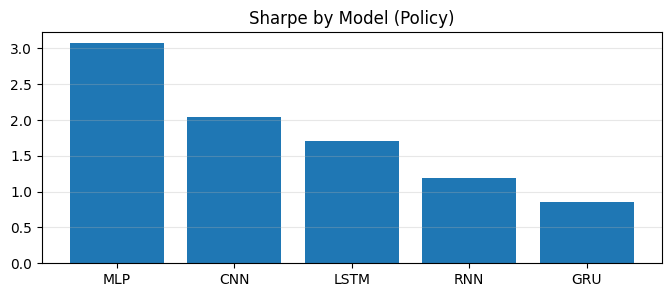


==== PLOTS for MLP ====


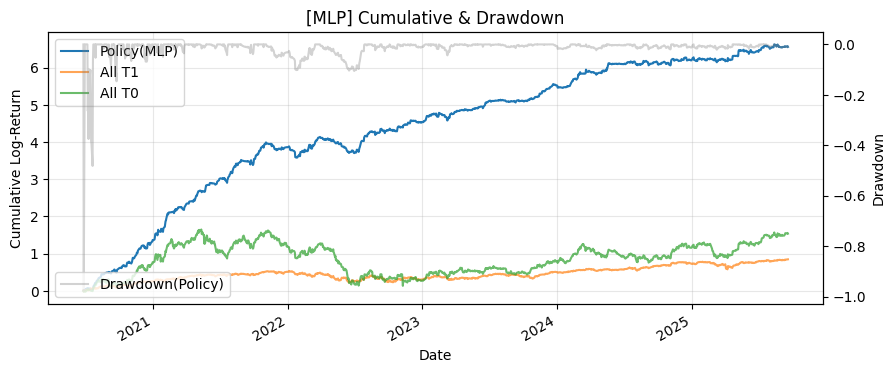

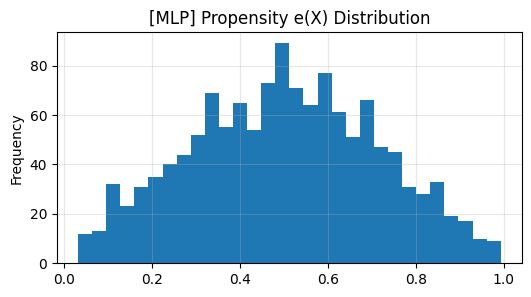

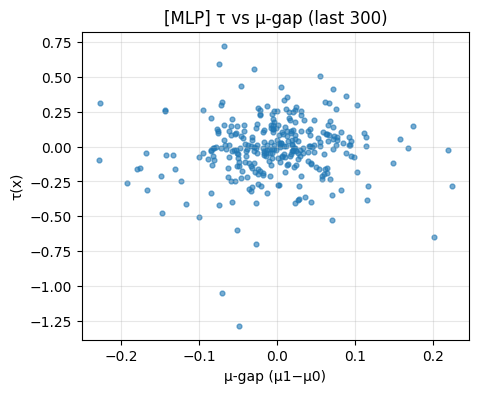


==== PLOTS for CNN ====


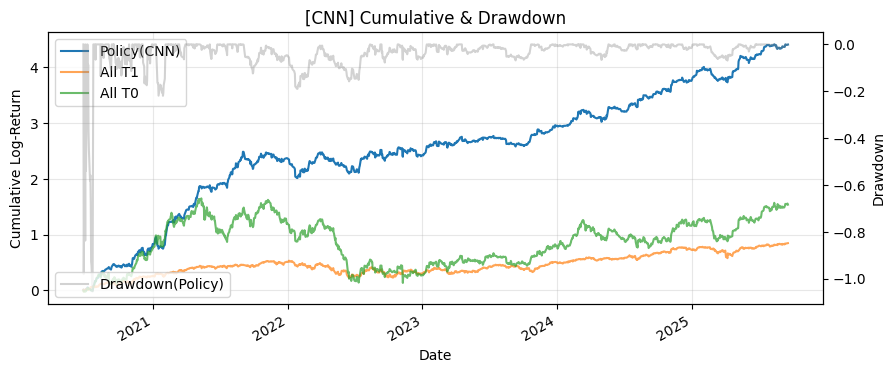

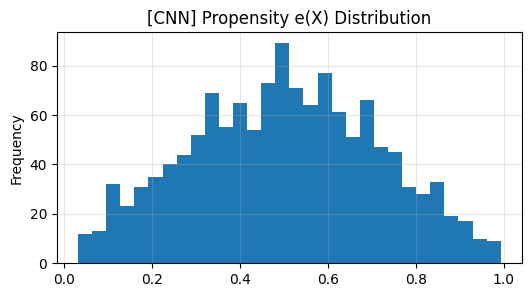

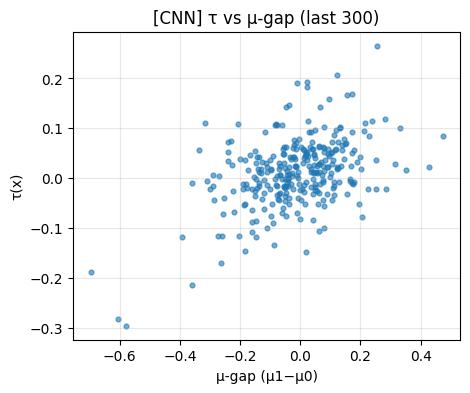


[Stats] Best=MLP  Sharpe=3.071
 - Paired t-test strat - T1: t=6.768, p(one-sided)=0.0000
 - Paired t-test strat - T0: t=5.423, p(one-sided)=0.0000


In [ ]:
# ============================================
# 전체 모델 일괄 테스트 + 결과/그래프/통계(옵션)
# - run_one(kind, CFG, X, y1, y0, data, return_components=True)를 사용
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MODEL_LIST = ["MLP","LSTM","GRU","CNN","RNN"]

def plot_for_kind(kind:str, comps:dict):
    """한 모델(kind)에 대해 누적+드로다운 / e(X) 분포 / τ vs μ-gap 플롯"""
    cum = comps["cum"]          # strat/all_t1/all_t0 누적 로그수익 (log-return 누적합)
    dd  = comps["dd"]           # strat 드로다운 시계열
    e   = comps["e"]            # 경향점수
    tau = comps["tau"]          # 최종 τ(x)
    mu_gap = comps["mu_gap"]    # μ1-μ0

    # (a) 누적 로그수익 + 드로다운(2축)
    fig, ax1 = plt.subplots(figsize=(10,4))
    cum["strat"].plot(ax=ax1, label=f"Policy({kind})")
    cum["all_t1"].plot(ax=ax1, label="All T1", alpha=0.7)
    cum["all_t0"].plot(ax=ax1, label="All T0", alpha=0.7)
    ax1.set_ylabel("Cumulative Log-Return"); ax1.grid(True, alpha=0.3); ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    dd.plot(ax=ax2, color="gray", alpha=0.35, label="Drawdown(Policy)")
    ax2.set_ylabel("Drawdown"); ax2.legend(loc="lower left")
    ax1.set_title(f"[{kind}] Cumulative & Drawdown")
    plt.show()

    # (b) e(X) 분포
    fig, ax = plt.subplots(figsize=(6,3))
    e.plot(kind="hist", bins=30, ax=ax)
    ax.set_title(f"[{kind}] Propensity e(X) Distribution")
    ax.grid(True, alpha=0.3)
    plt.show()

    # (c) τ vs μ-gap 산점도 (최근 300개)
    tmp = pd.concat([mu_gap, tau], axis=1).dropna().tail(300)
    tmp.columns = ["mu_gap", "tau"]
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(tmp["mu_gap"], tmp["tau"], s=12, alpha=0.6)
    ax.set_xlabel("μ-gap (μ1−μ0)"); ax.set_ylabel("τ(x)")
    ax.set_title(f"[{kind}] τ vs μ-gap (last 300)")
    ax.grid(True, alpha=0.3)
    plt.show()

# ---- (선택) 통계 유틸이 아직 없다면 간단 정의 ----
def _sharpe(r, ann=252):
    r = pd.Series(r).dropna()
    s = r.std()
    return (r.mean()/s*np.sqrt(ann)) if s>0 else 0.0

def _drawdown(cum):
    peak = cum.cummax()
    return cum/peak - 1.0

# (선택) 고급 통계(bootstrap, t-test, JK) 셀을 이미 추가했다면 사용.
# 없으면 간단 t-test만 추가:
try:
    from scipy import stats
    def paired_t_test_mean_diff(r_strat: pd.Series, r_bench: pd.Series, alternative="greater"):
        d = (pd.Series(r_strat).align(pd.Series(r_bench), join='inner')[0] -
             pd.Series(r_bench).align(pd.Series(r_strat), join='inner')[0]).dropna()
        t, p_two = stats.ttest_1samp(d, popmean=0.0, alternative='two-sided')
        if alternative == "two-sided": return t, p_two
        if alternative == "greater":   return t, (p_two/2 if t>0 else 1 - p_two/2)
        else:                          return t, (p_two/2 if t<0 else 1 - p_two/2)
except Exception:
    def paired_t_test_mean_diff(*args, **kwargs):
        return np.nan, np.nan

def run_all_models(models=MODEL_LIST, do_plots=True, do_stats=True, plot_top_k=1):
    """
    models: 테스트할 모델 리스트
    do_plots: Sharpe 바차트 + 상위 K개 상세 플롯
    do_stats: 상위 1개 모델에 대해 간단 t-test (고급 통계 셀을 쓴 경우 그쪽 사용 권장)
    plot_top_k: 상세 플롯을 그릴 상위 모델 개수
    반환: results_df, comps_map
    """
    results, comps_map = [], {}

    for kind in models:
        print(f"\n=== RUN {kind} ===")
        # run_one은 return_components=True 지원해야 함 (앞서 제공한 확장 버전)
        met, comps = run_one(kind, CFG, X, y1, y0, data, return_components=True)
        results.append(met)
        comps_map[kind] = comps

    results_df = pd.DataFrame(results)
    display(results_df.sort_values("Sharpe(strat)", ascending=False))

    # Sharpe 바차트
    if do_plots:
        order = results_df.sort_values("Sharpe(strat)", ascending=False)
        fig, ax = plt.subplots(figsize=(8,3))
        ax.bar(order["kind"], order["Sharpe(strat)"])
        ax.set_title("Sharpe by Model (Policy)")
        ax.grid(True, axis="y", alpha=0.3)
        plt.show()

        # 상위 K개 상세 플롯
        for kind in order["kind"].tolist()[:plot_top_k]:
            print(f"\n==== PLOTS for {kind} ====")
            plot_for_kind(kind, comps_map[kind])

    # 간단 유의성 검정 (상위 1개 모델)
    if do_stats:
        best_kind = results_df.sort_values("Sharpe(strat)", ascending=False).iloc[0]["kind"]
        c = comps_map[best_kind]
        r_strat = c["df"]["strat"]; r_t1 = c["df"]["all_t1"]; r_t0 = c["df"]["all_t0"]
        t1, p1 = paired_t_test_mean_diff(r_strat, r_t1, alternative="greater")
        t0, p0 = paired_t_test_mean_diff(r_strat, r_t0, alternative="greater")
        print(f"\n[Stats] Best={best_kind}  Sharpe={_sharpe(r_strat):.3f}")
        print(f" - Paired t-test strat - T1: t={t1:.3f}, p(one-sided)={p1:.4f}")
        print(f" - Paired t-test strat - T0: t={t0:.3f}, p(one-sided)={p0:.4f}")

    return results_df, comps_map

# === 실행 예시 ===
results_df, comps_map = run_all_models(
    models=MODEL_LIST,
    do_plots=True,     # 바차트/상세 플롯
    do_stats=True,     # 간단 t-test
    plot_top_k=2       # 상위 2개 모델 상세 플롯
)
